In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import os
import numpy as np
from datetime import datetime, timedelta
import math
import json
from collections import Counter
from adjustText import adjust_text
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = [25, 10]

In [4]:
index_list_names = [
    "loadtest-webrtc-2024-kurento-2p",
    "loadtest-webrtc-2024-kurento-8p",
    "loadtest-webrtc-2024-kurento-3p-10s",
    "loadtest-webrtc-2024-kurento-3p-40s",
    "loadtest-webrtc-2024-pion-2p",
    "loadtest-webrtc-2024-pion-8p",
    "loadtest-webrtc-2024-pion-3p-10s",
    "loadtest-webrtc-2024-pion-3p-40s",
]

In [6]:
def read_file(path):
    if os.path.exists(path):
        with open(path, 'r') as f:
            return json.load(f)
    else:
        return []

def get_index_data(index_list_name, data_type):
    full_user_data = []
    for entry in os.scandir(f'stats/{index_list_name}'):
        if entry.is_dir():
            for sub_entry in os.scandir(entry.path):
                if sub_entry.is_dir():
                    # check that file exists
                    data = read_file(os.path.join(sub_entry.path, data_type + '.json'))
                    full_user_data.append({
                        'user': sub_entry.name,
                        'session': entry.name,
                        data_type: data
                    })
    return full_user_data


seconds_per_fragment = 17

In [7]:
events_dfs = {}
for index_list_name in index_list_names:
    data = []
    user_data = get_index_data(index_list_name, "events")
    for user in user_data:
        for event in user['events']:
            data.append({
                'user': int(user['user'].replace("User", "")),
                'session': int(user['session'].replace("LoadTestSession", "")),
                'event': event['event'] + (f"-{event['connection']}" if 'connection' in event else ""),
                'connection': event['connection'] if 'connection' in event else None,
                'timestamp': event['timestamp'],
                'publishers': 0,
                'subscribers': 0,
                'streams_in': 0,
                'streams_out': 0
            })
    events_df = pd.DataFrame(data)
    # convert timestamp to datetime
    events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])
    # sort by timestamp
    events_df = events_df.sort_values(by='timestamp')
    events_dfs[index_list_name] = events_df

In [8]:
def add_to(array, number, user, session, timestamp):
    array.append({
        "number": number,
        "user": user,
        "session": session,
        "timestamp": timestamp
    })
full_publishers_progression = {}
full_subscribers_progression = {}
full_streams_in_progression = {}
full_streams_out_progression = {}
for index_list_name in index_list_names:
    events_df = events_dfs[index_list_name]
    sessions = events_df['session'].unique()
    publishers_progression = []
    subscribers_progression = []
    streams_in_progression = []
    streams_out_progression = []
    previous_data = {
        'publishers': 0,
        'subscribers': 0,
        'streams_in': 0,
        'streams_out': 0
    }
    for session in sessions:
        previous_data[session] = {
            'publishers': 0,
            'subscribers': 0,
        }
    # iterate through event_df rows
    for i, row in events_df.iterrows():
        session = row['session']
        user = row['user']
        event = row['event']
        connection = row['connection']
        # publisher joins
        if event == 'streamCreated' and connection == 'local':
            if ("0s" in index_list_name) and (user > 3):
                # new user is subscriber
                subscribers = previous_data['subscribers'] + 1
                events_df.at[i, 'subscribers'] = subscribers
                publishers_in_session = previous_data[session]['publishers']
                subscribers_in_session = previous_data[session]['subscribers'] + 1
                streams_out = 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session * publishers_in_session
                events_df.at[i, 'streams_out'] = streams_out
                previous_data['subscribers'] = subscribers
                previous_data[session]['subscribers'] = subscribers_in_session
            else:
                # new user is publisher
                publishers = previous_data['publishers'] + 1
                events_df.at[i, 'publishers'] = publishers
                streams_in = previous_data['streams_in'] + 2
                events_df.at[i, 'streams_in'] = streams_in
                publishers_in_session = previous_data[session]['publishers'] + 1
                subscribers_in_session = previous_data[session]['subscribers']
                streams_out = 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session * publishers_in_session
                events_df.at[i, 'streams_out'] = streams_out
                previous_data['publishers'] = publishers
                previous_data[session]['publishers'] = publishers_in_session
            previous_data['streams_in'] = streams_in
            previous_data['streams_out'] = streams_out
            add_to(publishers_progression, publishers, user, session, row['timestamp'])
            add_to(subscribers_progression, previous_data['subscribers'], user, session, row['timestamp'])
            add_to(streams_in_progression, streams_in, user, session, row['timestamp'])
            add_to(streams_out_progression, streams_out, user, session, row['timestamp'])

        # publisher leaves
        elif event == 'streamDestroyed' and connection == 'local':
            if ("0s" in index_list_name) and (user > 3):
                subscribers = previous_data['subscribers'] - 1
                events_df.at[i, 'subscribers'] = subscribers
                publishers_in_session = previous_data[session]['publishers']
                subscribers_in_session = previous_data[session]['subscribers'] - 1
                streams_out = 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session * publishers_in_session
            else:
                publishers = previous_data['publishers'] - 1
                events_df.at[i, 'publishers'] = publishers
                streams_in = previous_data['streams_in'] - 2
                events_df.at[i, 'streams_in'] = streams_in
                publishers_in_session = previous_data[session]['publishers'] - 1
                subscribers_in_session = previous_data[session]['subscribers']
                streams_out = 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session * publishers_in_session
                events_df.at[i, 'streams_out'] = streams_out
                previous_data['publishers'] = publishers
                previous_data[session]['publishers'] = publishers_in_session
            previous_data['streams_in'] = streams_in
            previous_data['streams_out'] = streams_out
            add_to(publishers_progression, publishers, user, session, row['timestamp'])
            add_to(subscribers_progression, previous_data['subscribers'], user, session, row['timestamp'])
            add_to(streams_in_progression, streams_in, user, session, row['timestamp'])
            add_to(streams_out_progression, streams_out, user, session, row['timestamp'])
        else:
            events_df.at[i, 'publishers'] = previous_data['publishers']
            events_df.at[i, 'subscribers'] = previous_data['subscribers']
            events_df.at[i, 'streams_in'] = previous_data['streams_in']
            events_df.at[i, 'streams_out'] = previous_data['streams_out']
    publishers_progression = pd.DataFrame(publishers_progression)
    subscribers_progression = pd.DataFrame(subscribers_progression)
    streams_in_progression = pd.DataFrame(streams_in_progression)
    streams_out_progression = pd.DataFrame(streams_out_progression)
    full_publishers_progression[index_list_name] = publishers_progression
    full_subscribers_progression[index_list_name] = subscribers_progression
    full_streams_in_progression[index_list_name] = streams_in_progression
    full_streams_out_progression[index_list_name] = streams_out_progression

In [9]:
# read log file and get specific lines with regex
import re
failures = {}
regex = '(.*) ERROR .* Participant (.*) in session (.*) failed (.) times'
date_format = "%Y-%m-%d %H:%M:%S.%f %z"
for index_list_name in index_list_names:
    log_file = f'logs/{index_list_name}.log'
    with open(log_file, 'r') as f:
        lines = f.readlines()
        failed_attempts = []
        for line in lines:
            if 'Participant' in line:
                match = re.search(regex, line)
                if match:
                    failed_attempts.append({
                        'user': match.group(2).replace('User', ''),
                        'session': match.group(3).replace('LoadTestSession', ''),
                        'attempts': match.group(4),
                        'timestamp': datetime.strptime(match.group(1)+" +0200", date_format),
                        'full_user': f"{match.group(2).replace('User', '')}-{match.group(3).replace('LoadTestSession', '')}",
                    })
    failures[index_list_name] = pd.DataFrame(failed_attempts)

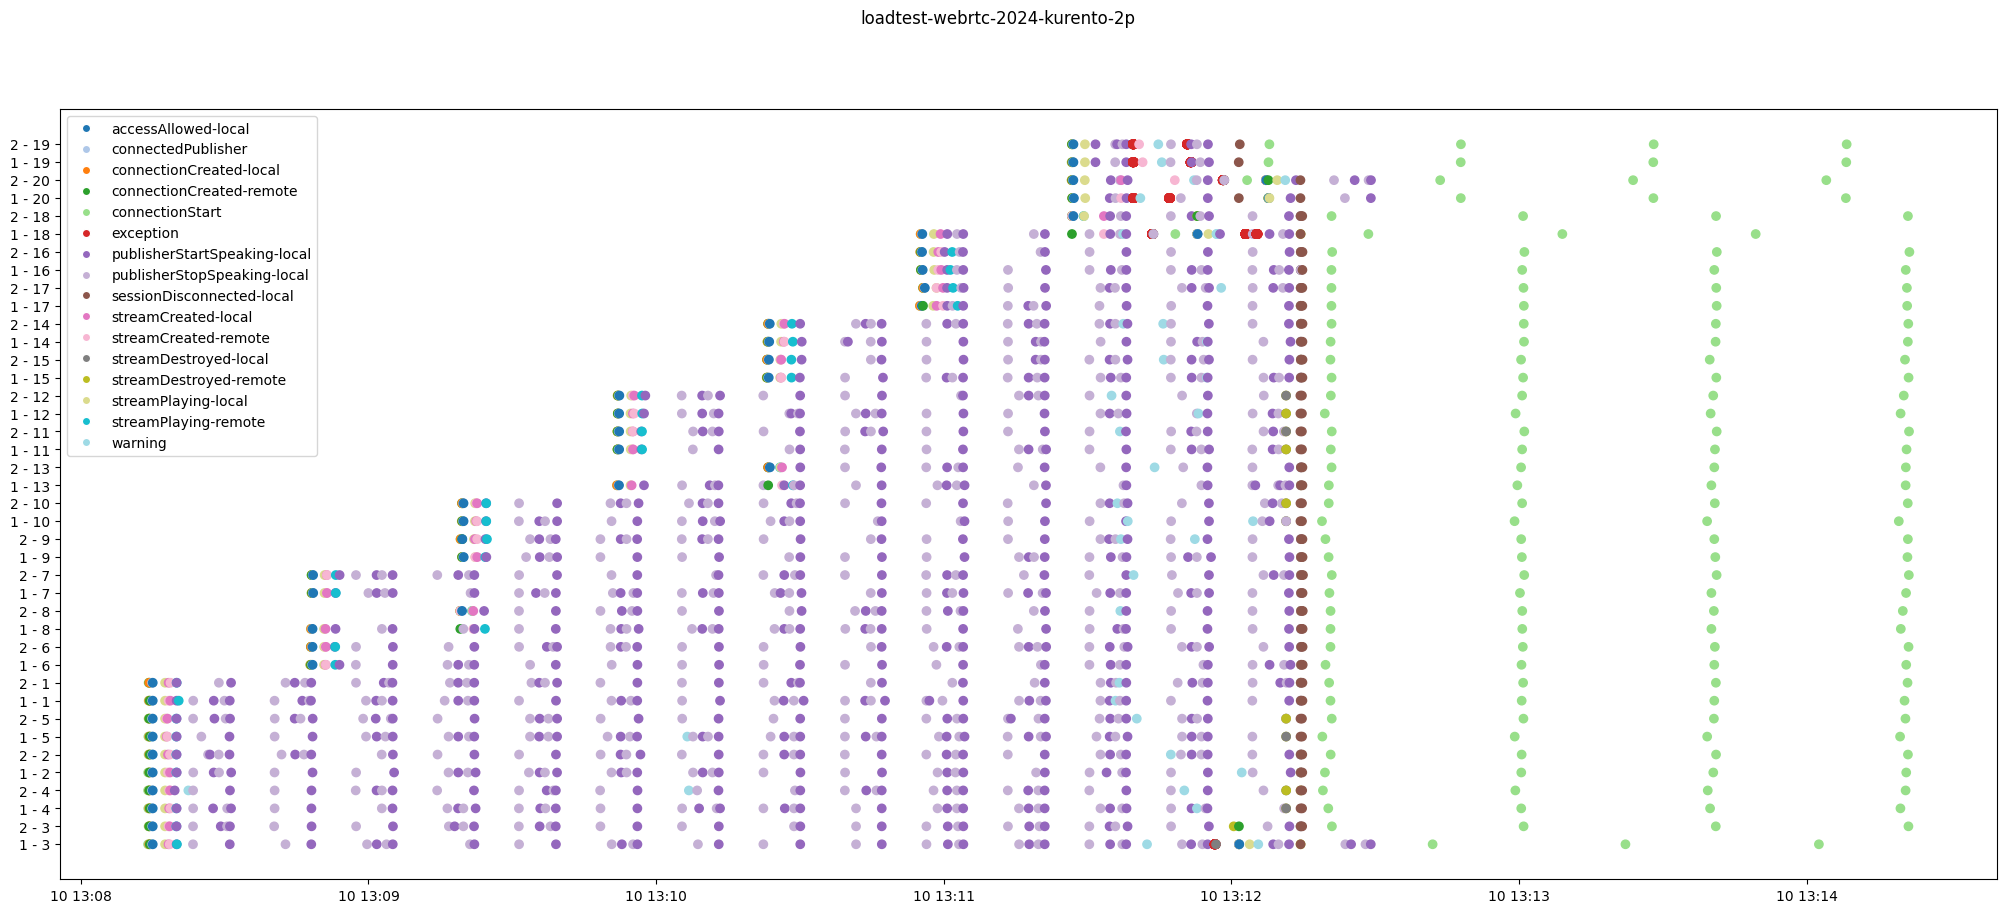

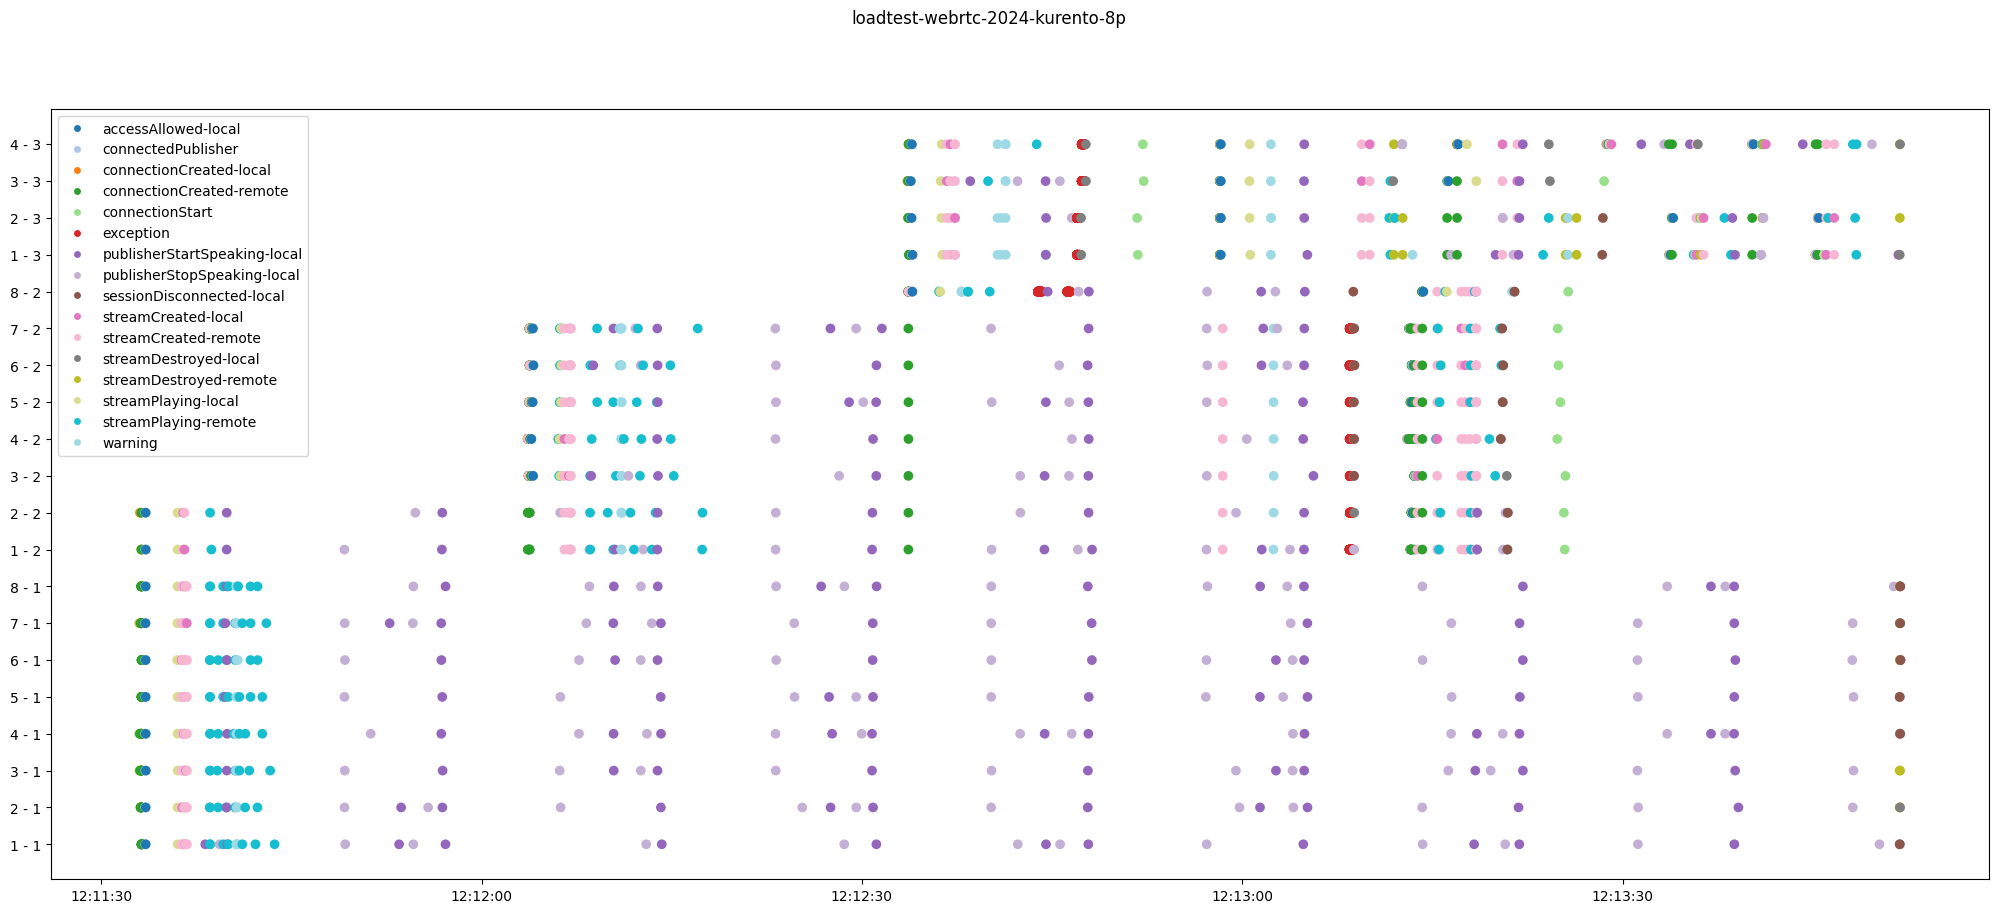

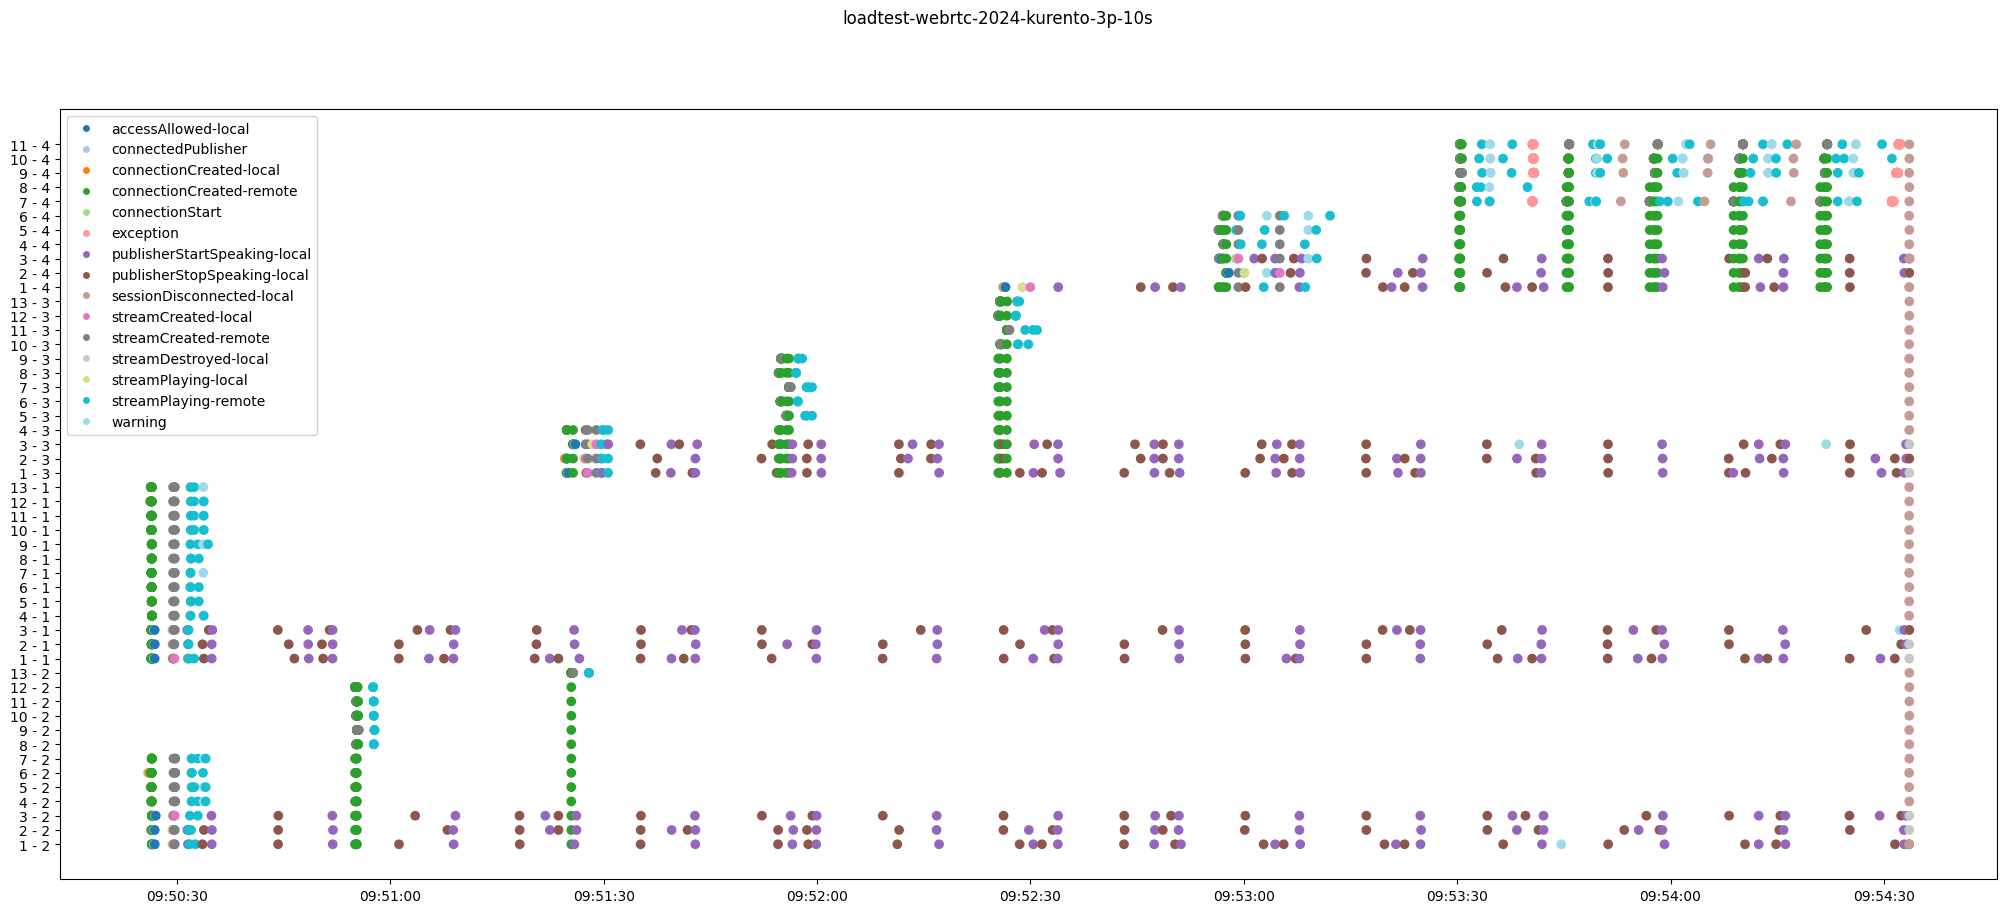

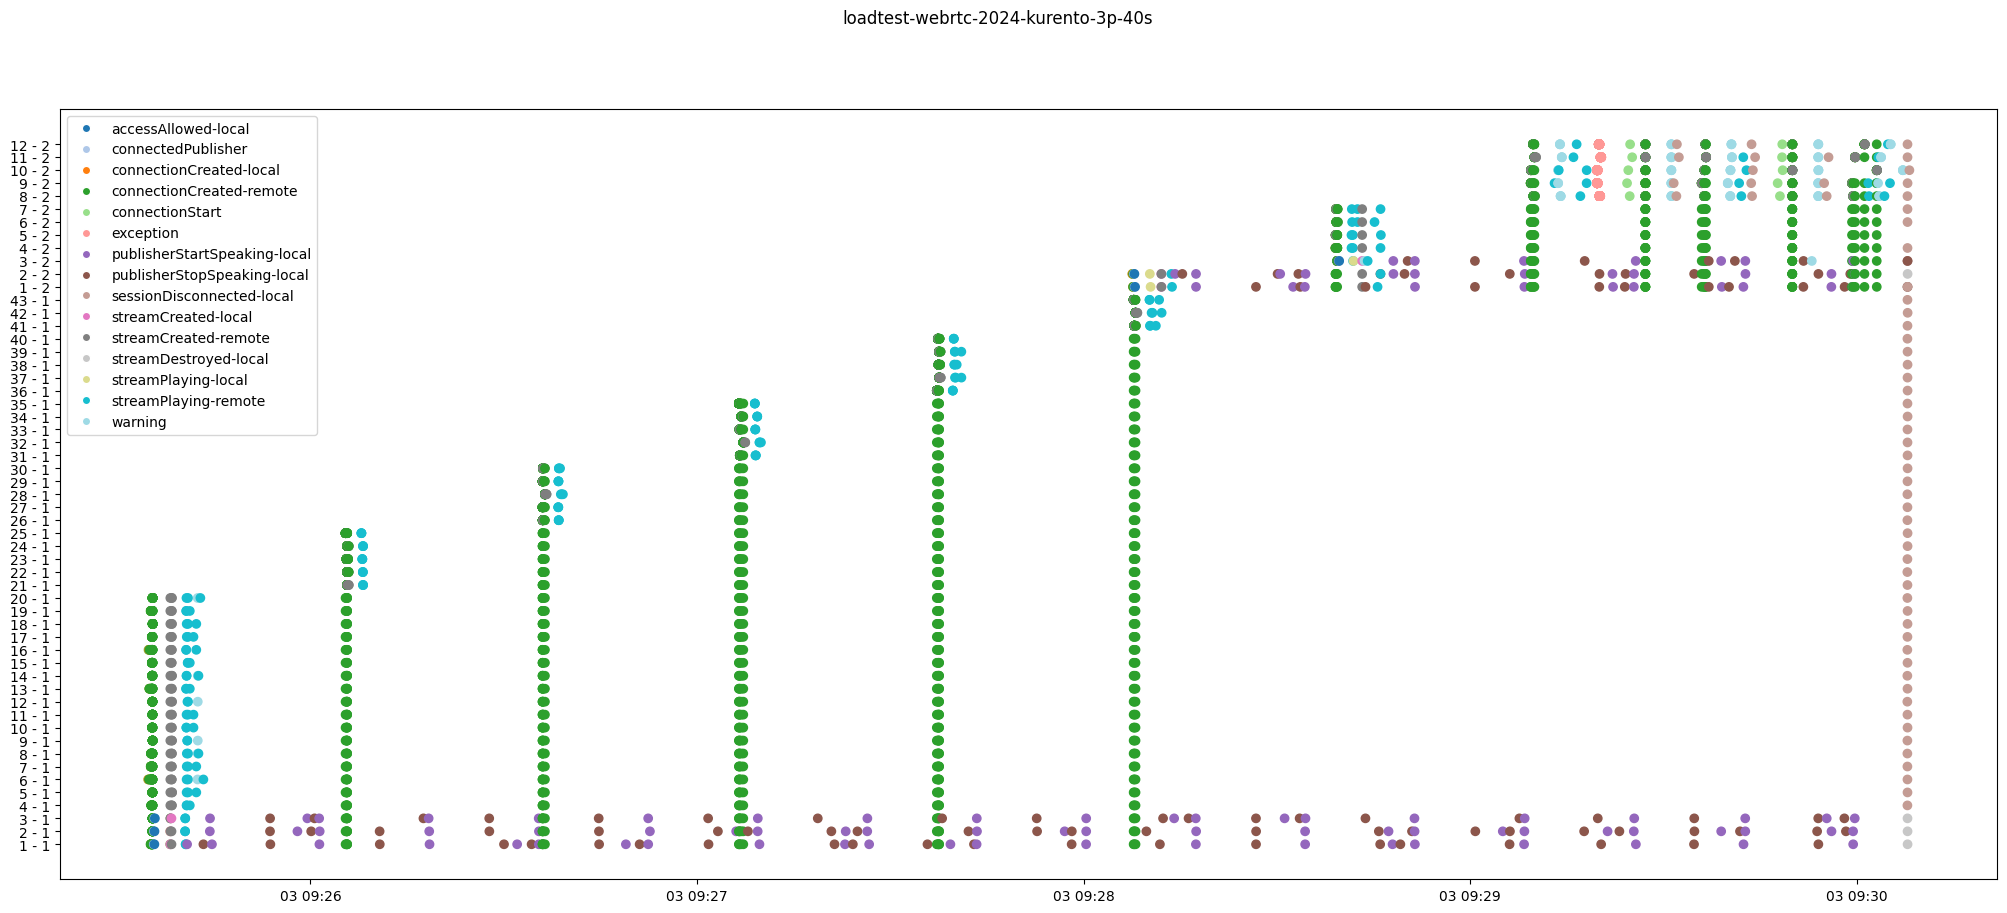

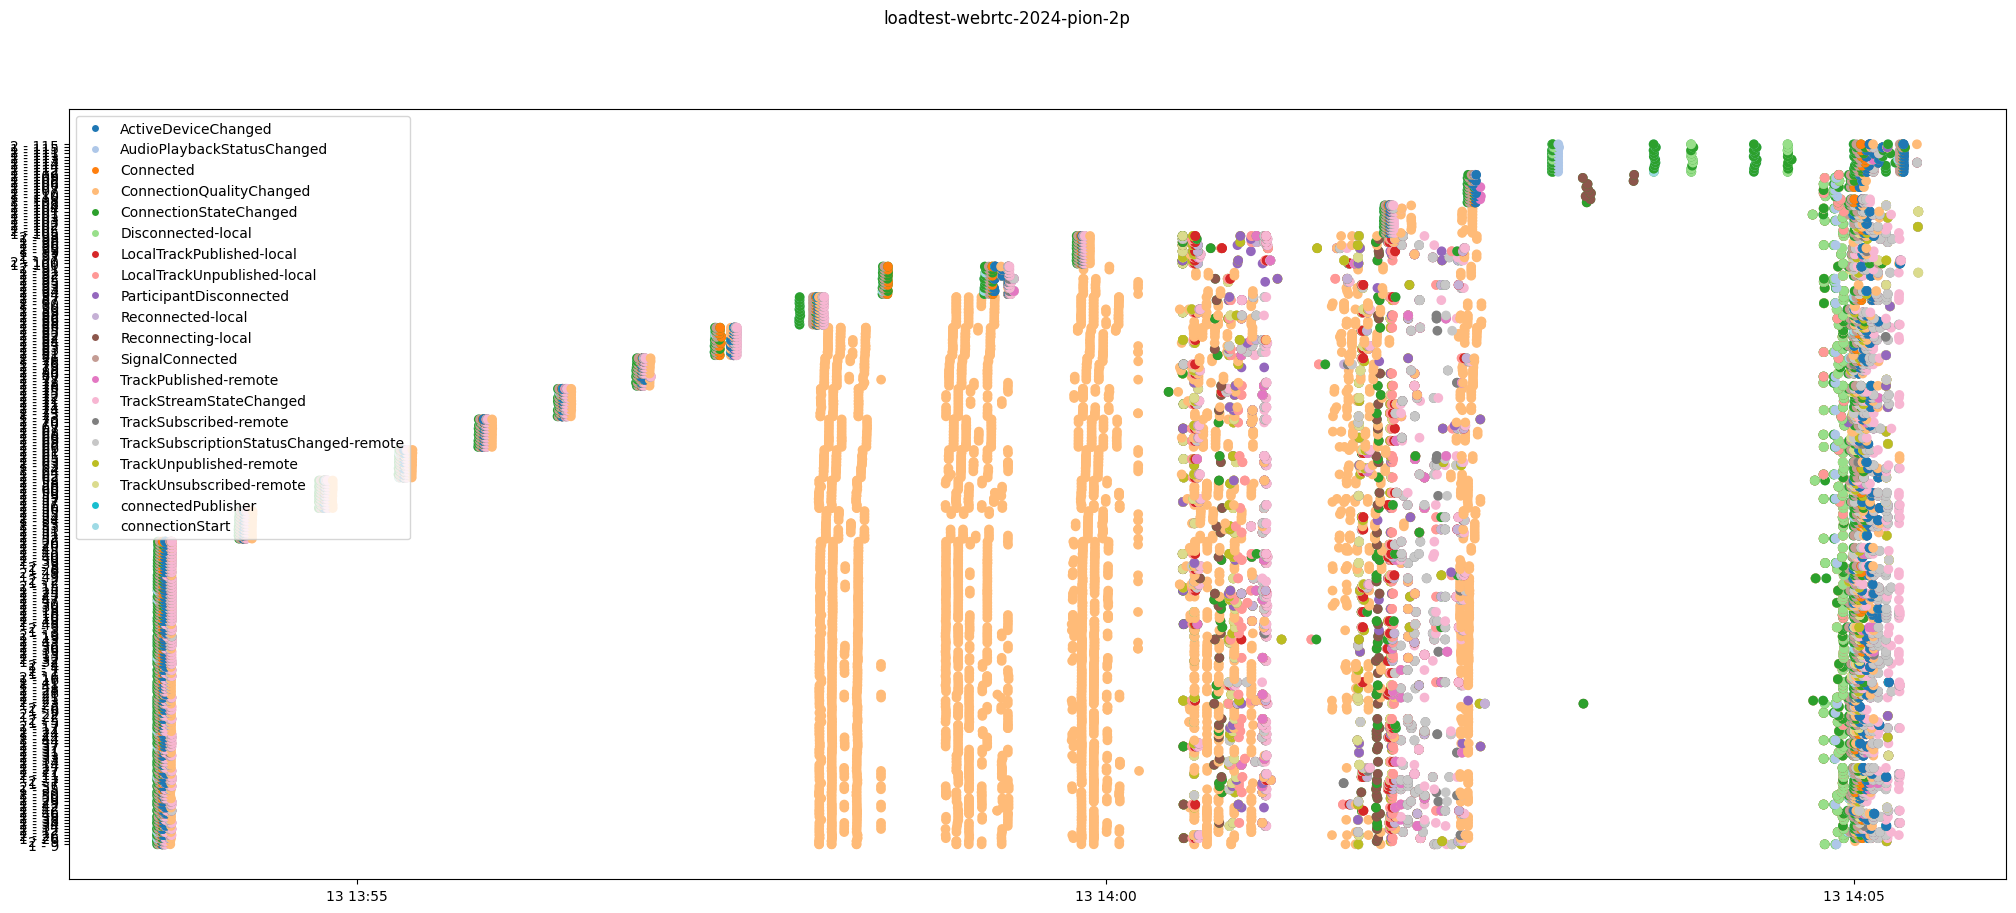

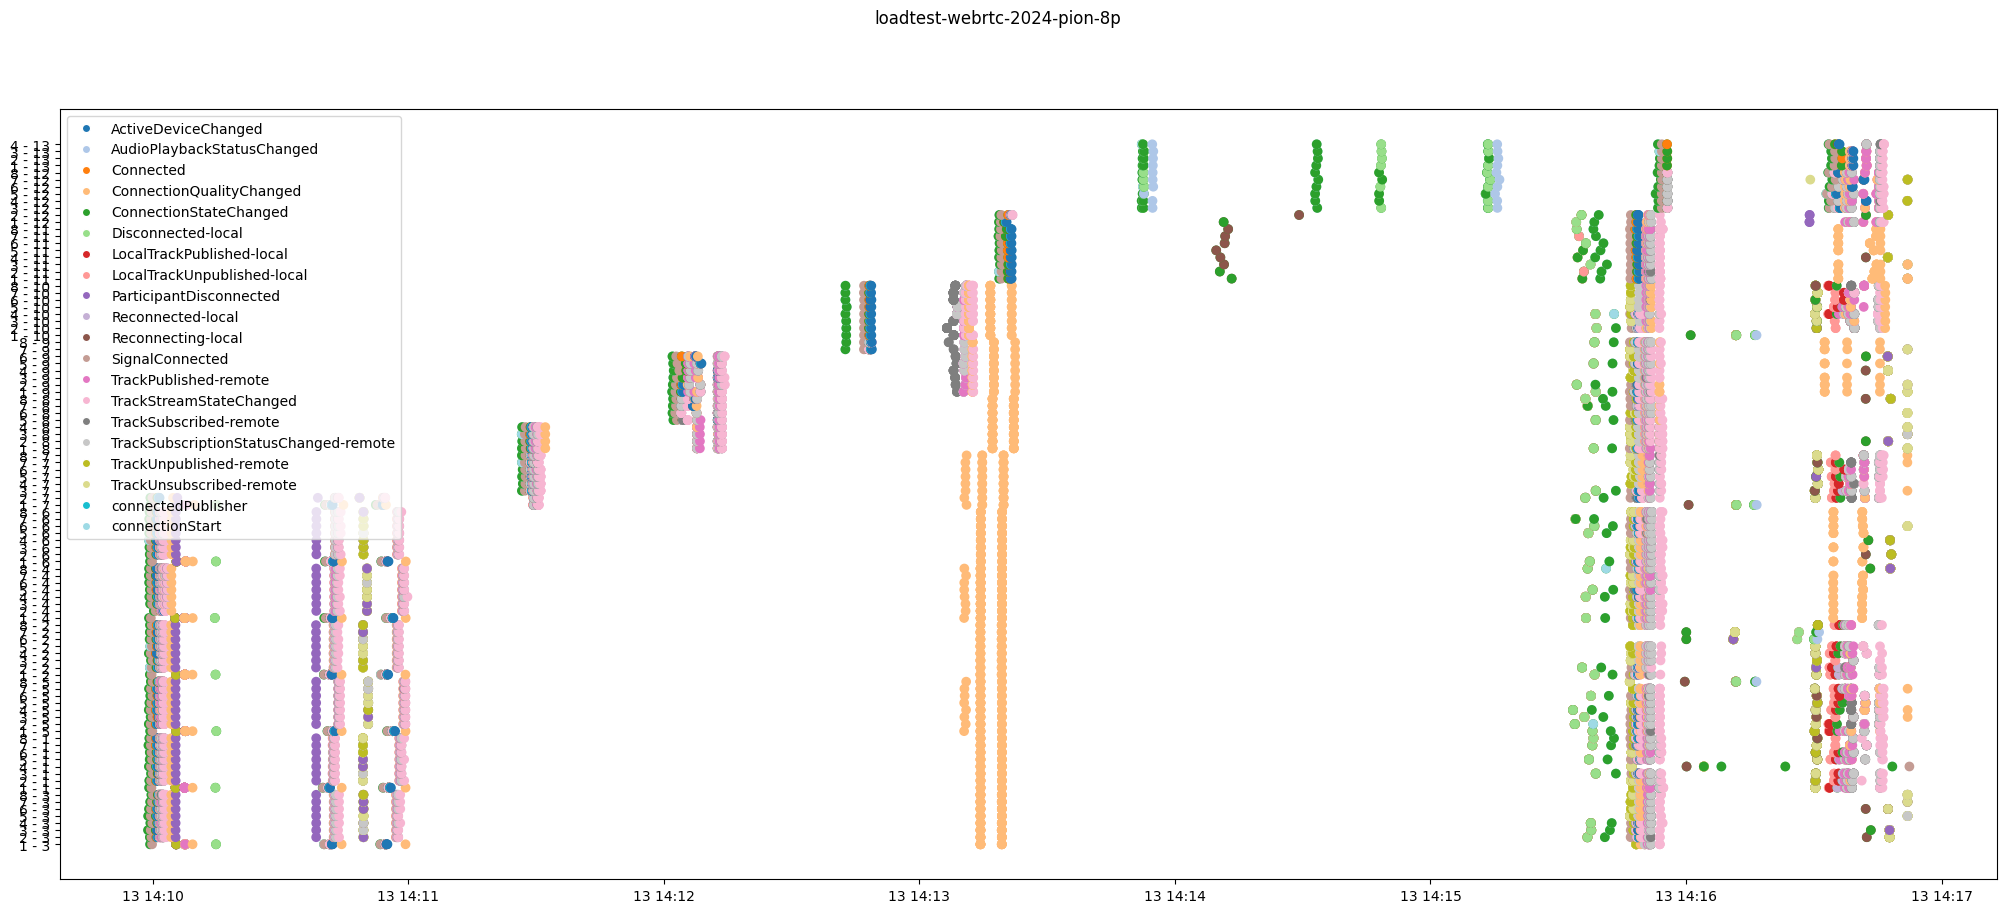

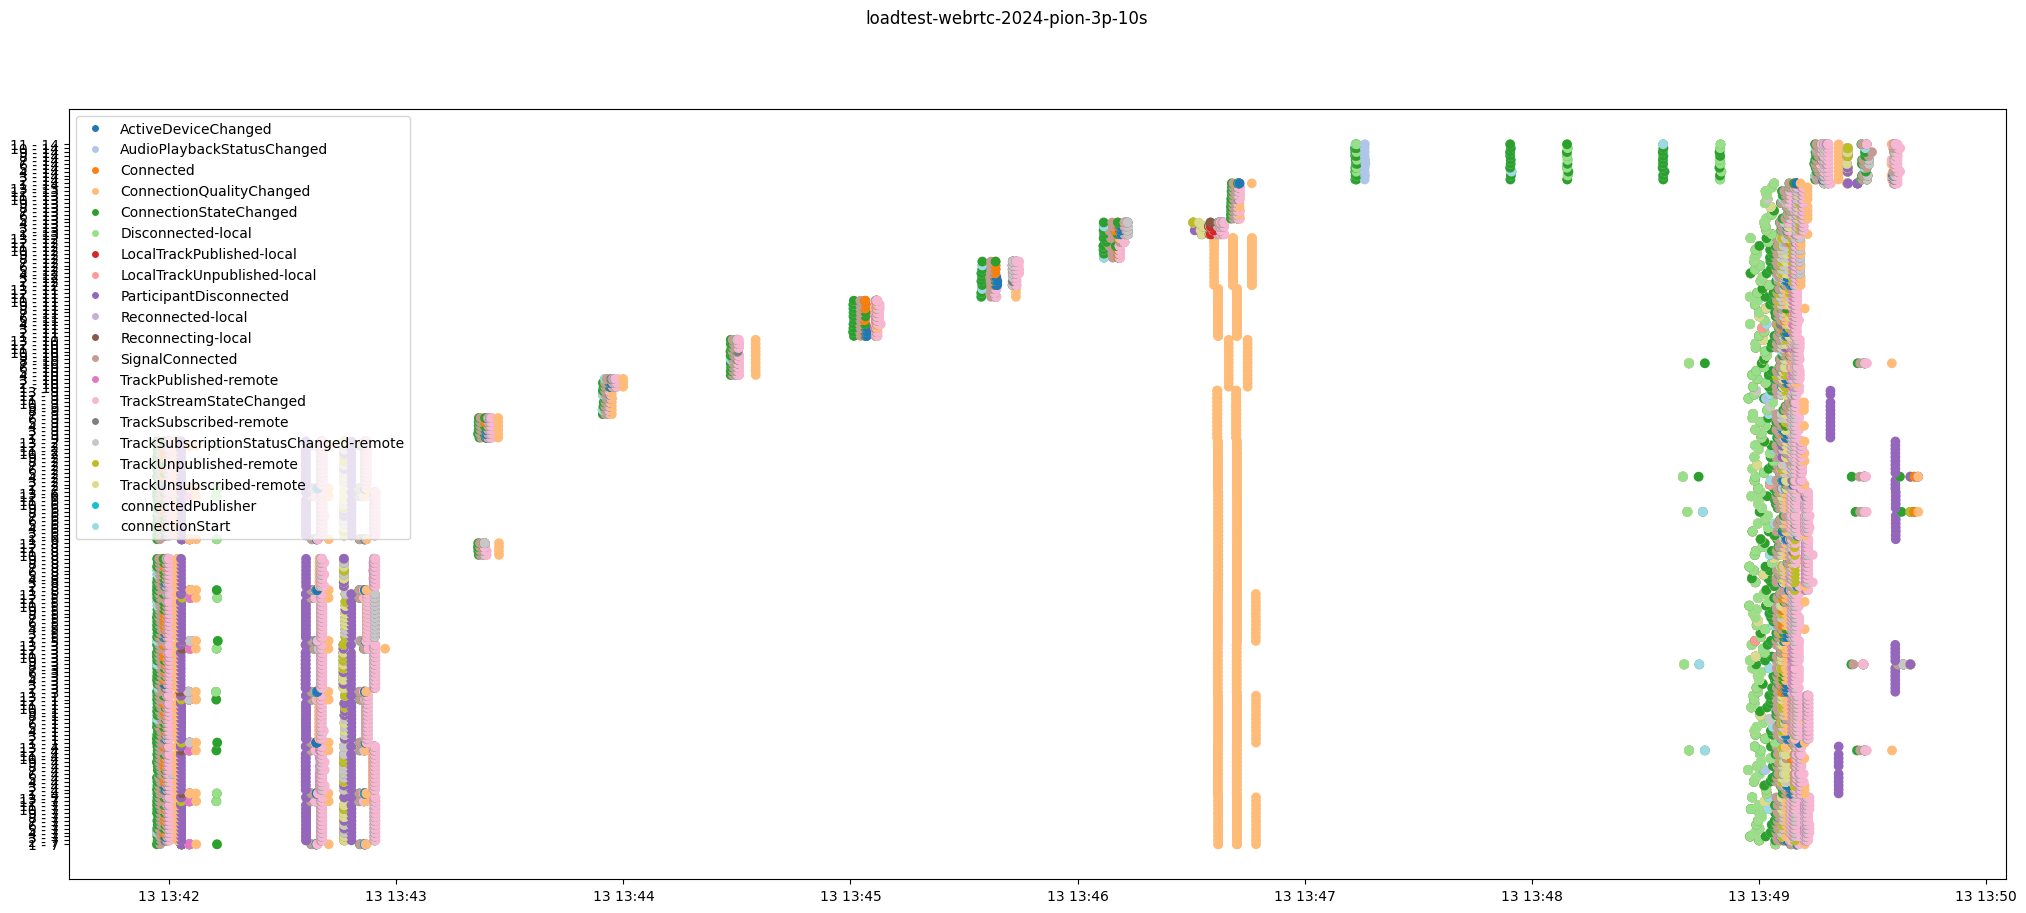

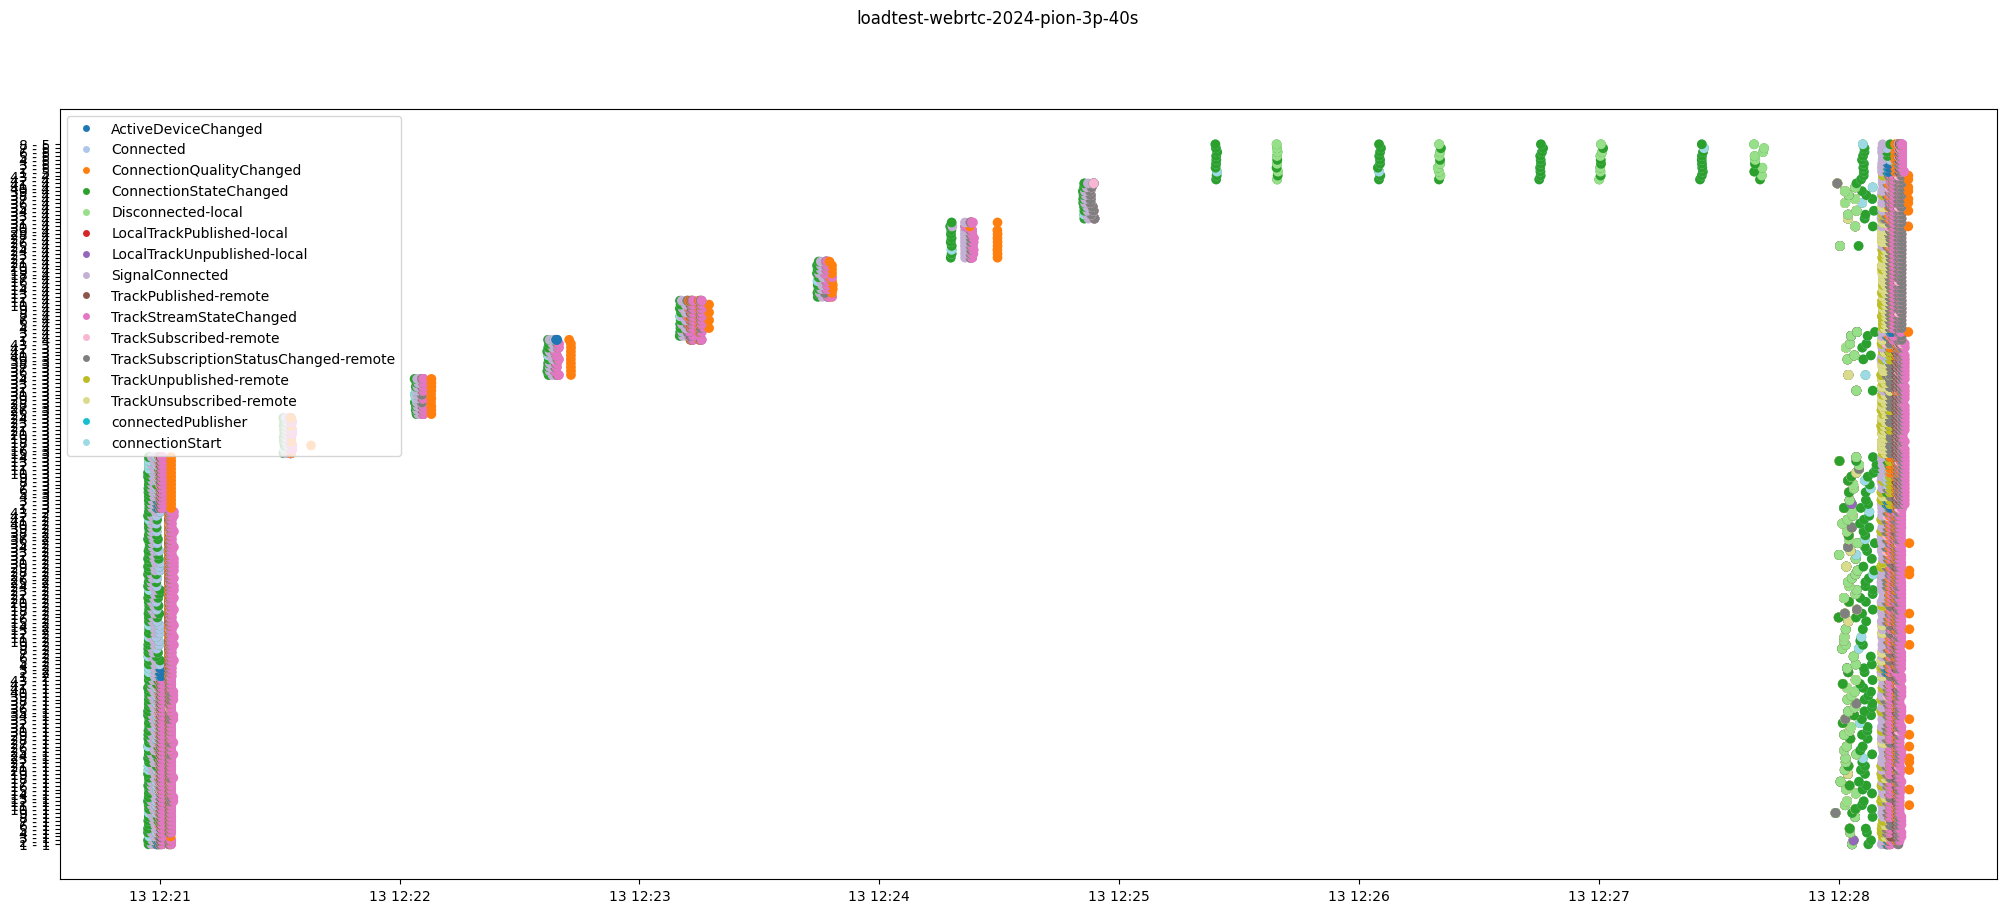

In [10]:
for test in events_dfs.keys():
    events_df = events_dfs[test]
    events_df = events_df.sort_values(by=["session", "user", "timestamp"])
    fig, ax = plt.subplots()
    event_types = events_df['event'].unique()
    event_types.sort()
    colors = mpl.colormaps.get_cmap('tab20')(np.linspace(0, 1, len(event_types)))
    event_color = dict(zip(event_types, colors))
    y_labels = []
    y_ticks = 0
    for session in events_dfs[test]['session'].unique():
        events_df_session = events_df[events_df['session'] == session]
        for user in events_df_session['user'].unique():
            events_df_user = events_df_session[events_df_session['user'] == user]
            y_ticks += 1
            y_pos = [y_ticks] * len(events_df_user)
            ax.scatter(events_df_user['timestamp'], y_pos, c=[event_color[event] for event in events_df_user['event']])
            y_labels.append(f'{user} - {session}')

    # add legend
    legend_labels = []
    for event, color in event_color.items():
        legend_labels.append(plt.Line2D([0], [0], marker='o', color='w', label=event, markerfacecolor=color))
    ax.legend(handles=legend_labels, loc='upper left')
    fig.suptitle(f'{test}')
    # y labels should be user - session
    ax.set_yticks(range(1, y_ticks + 1))
    ax.set_yticklabels(y_labels)


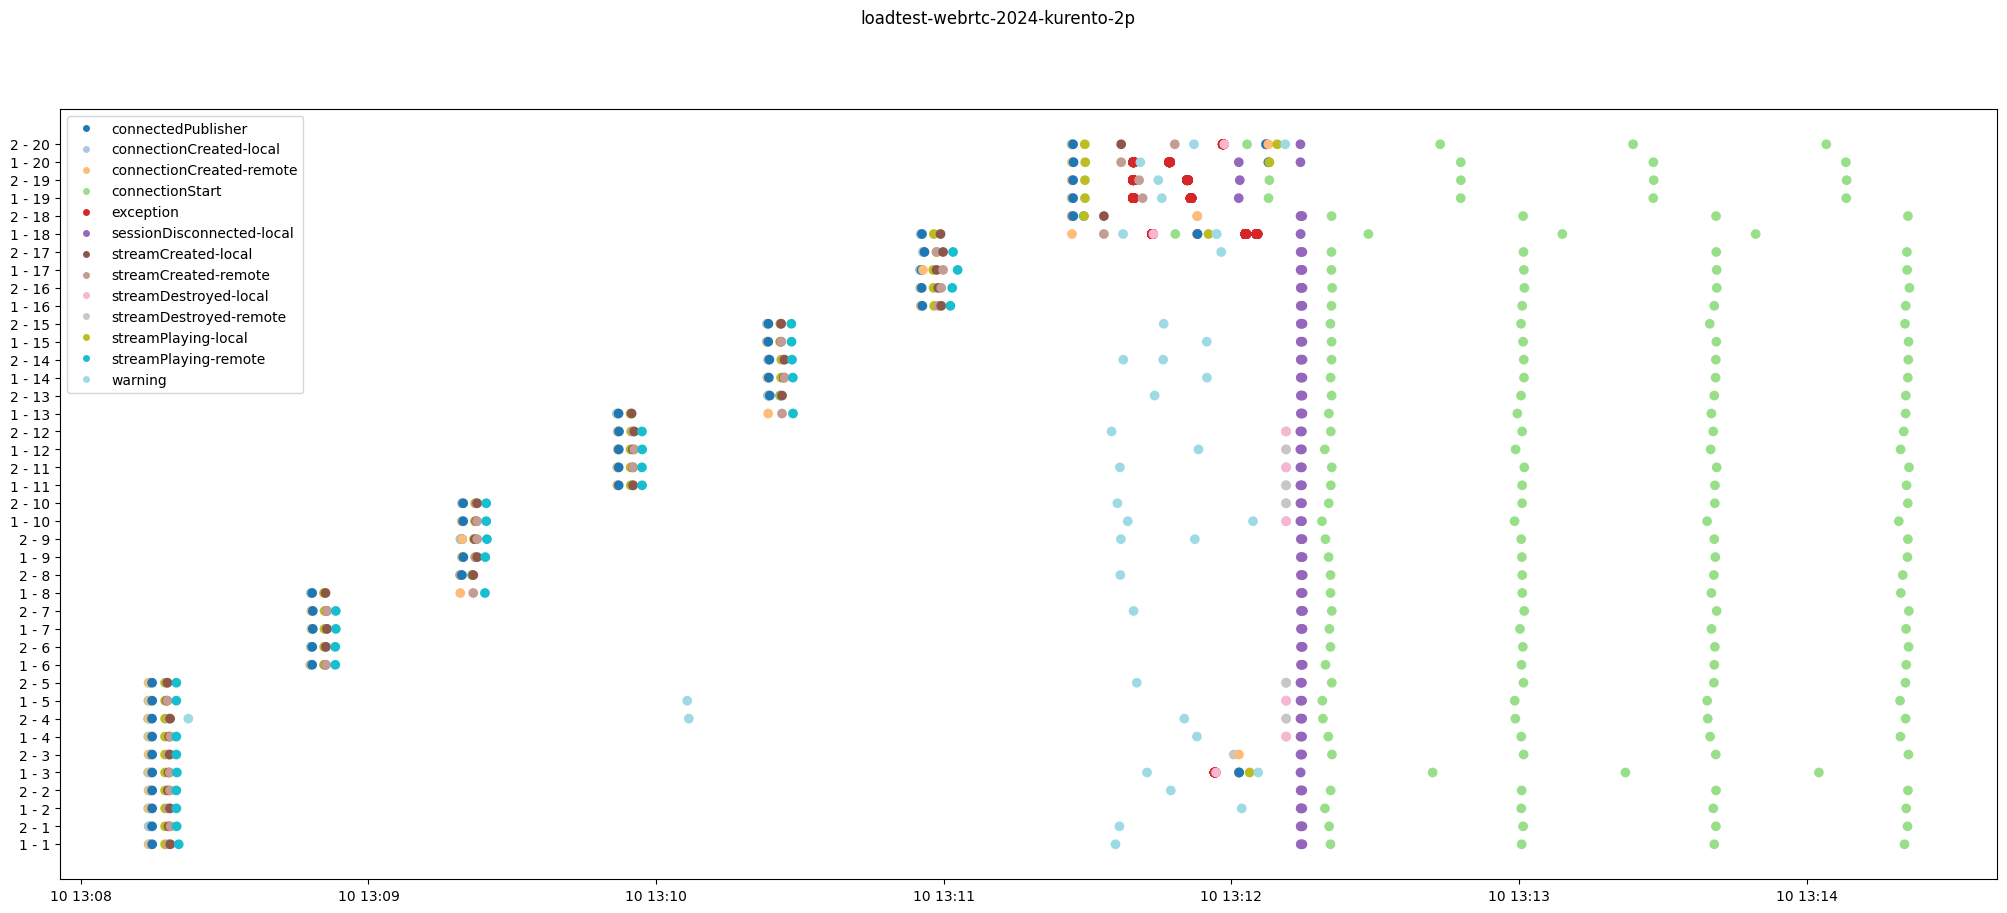

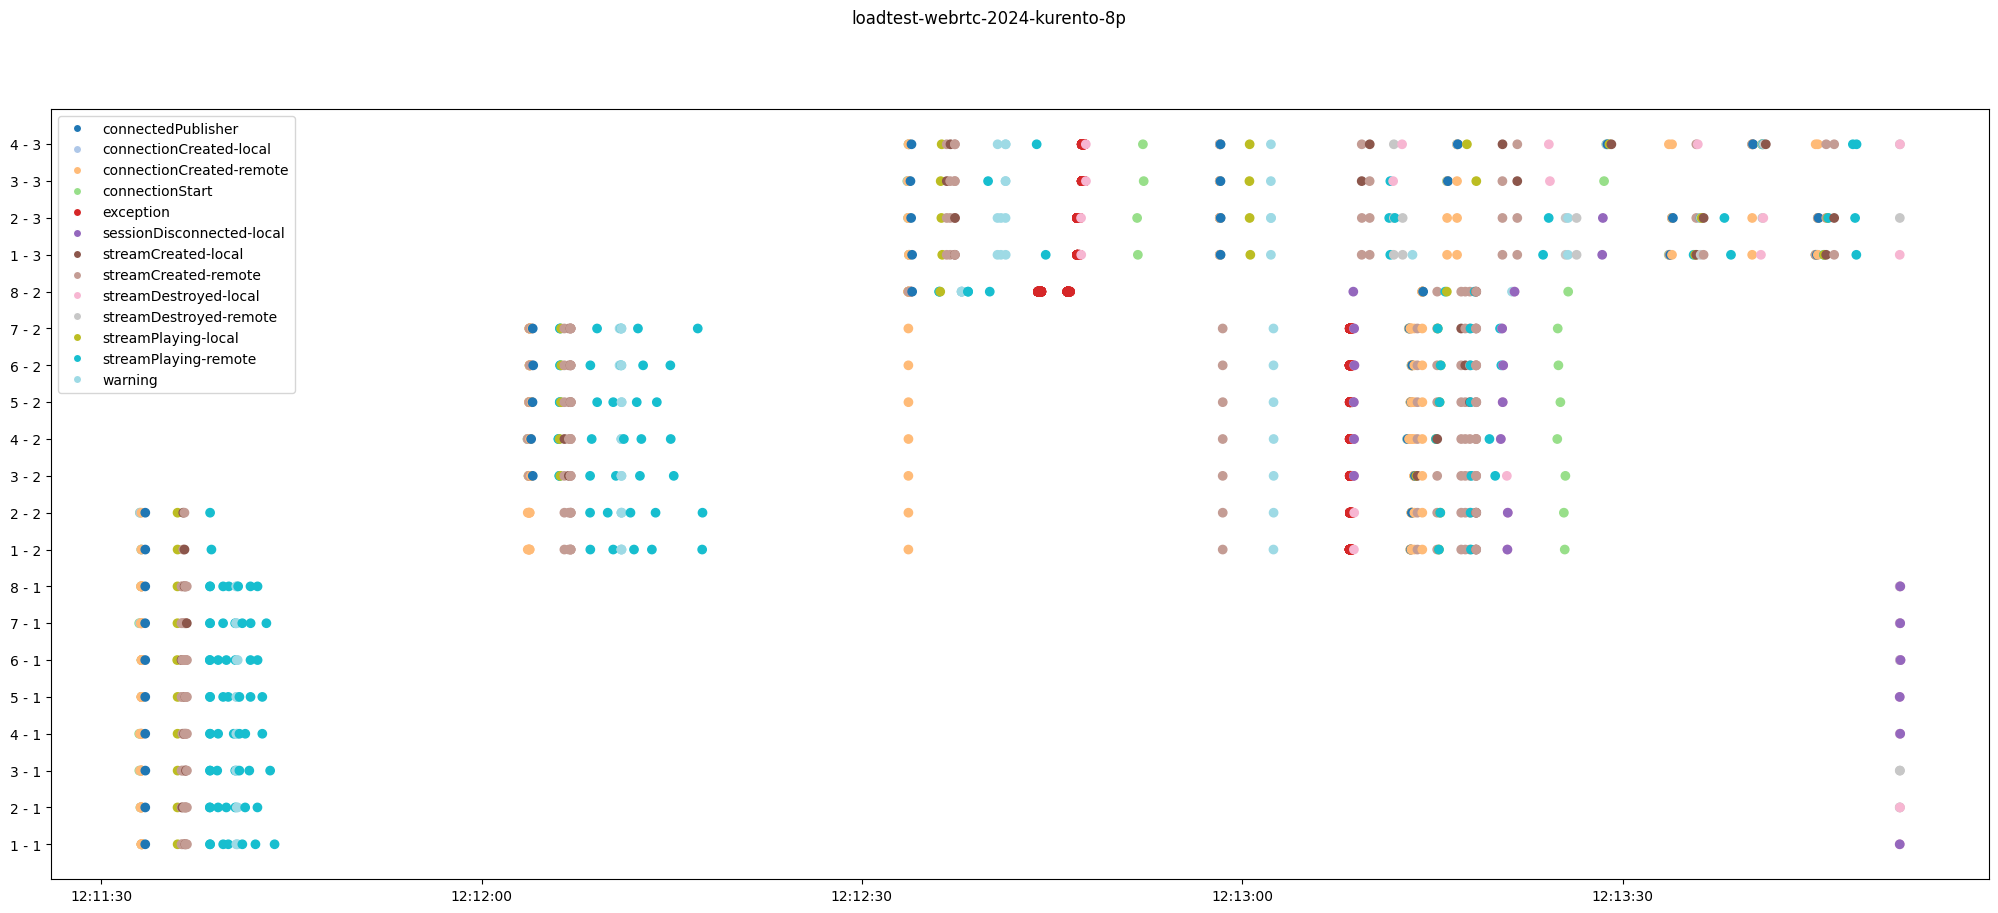

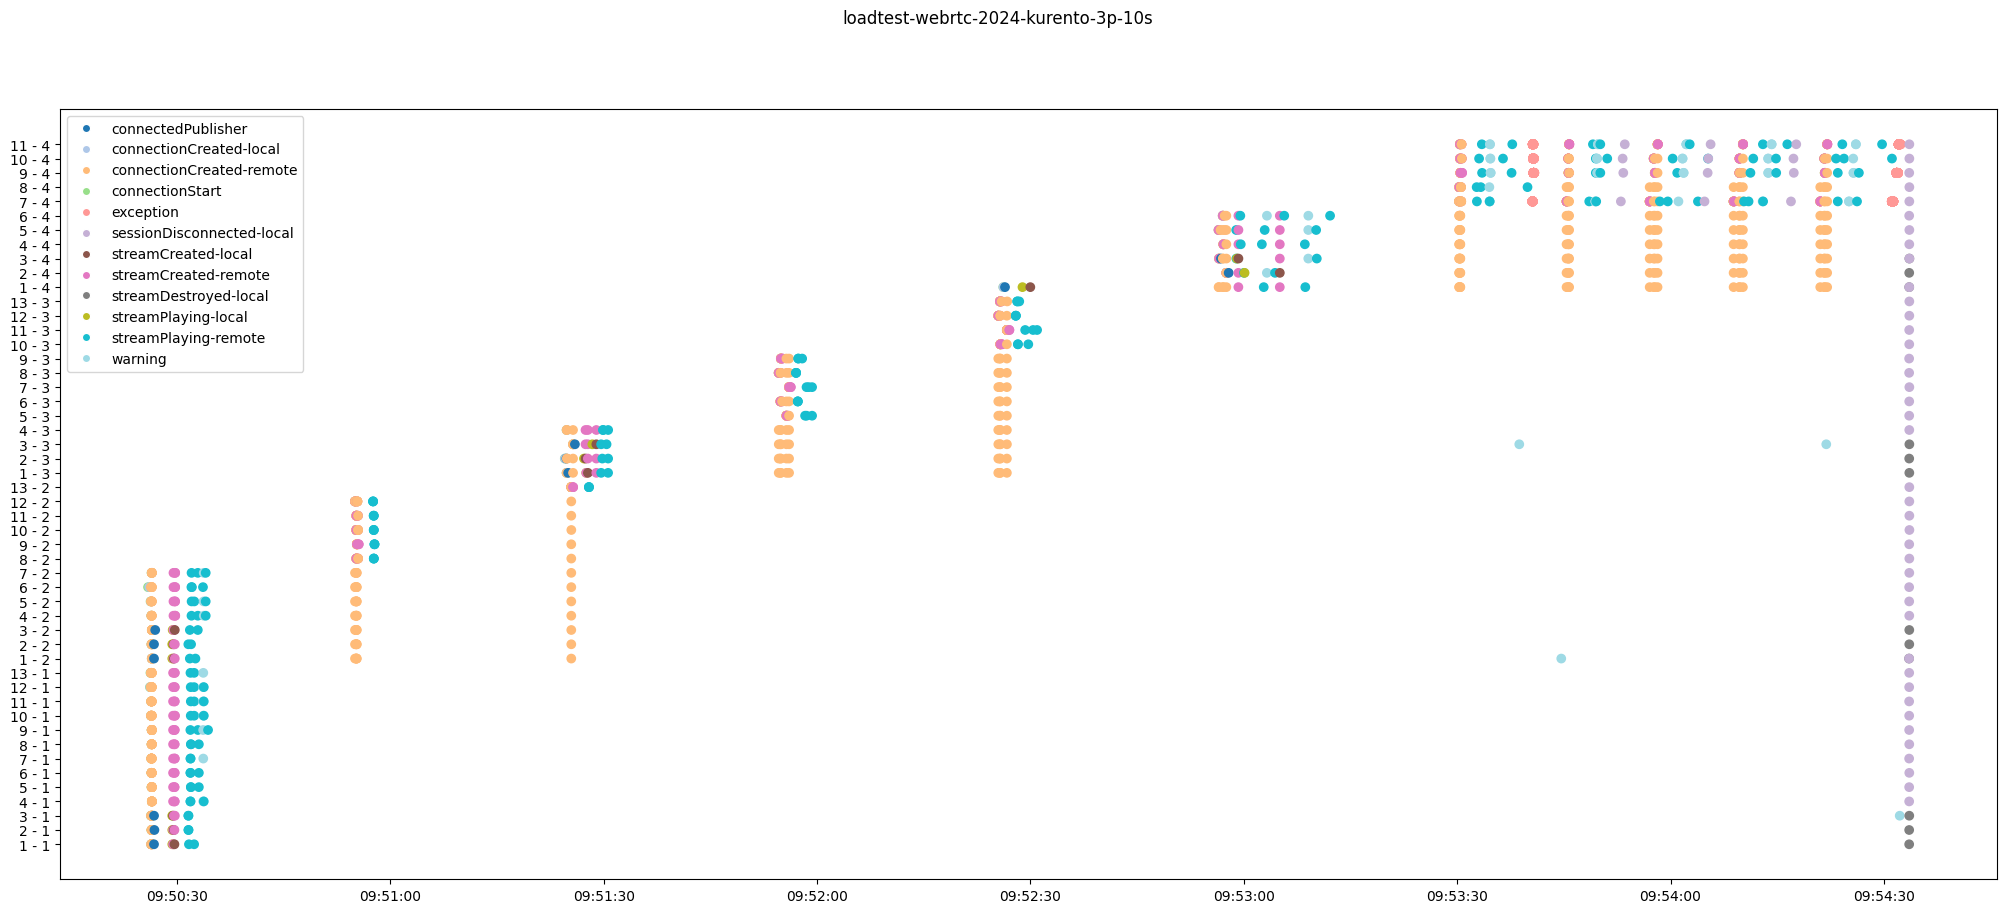

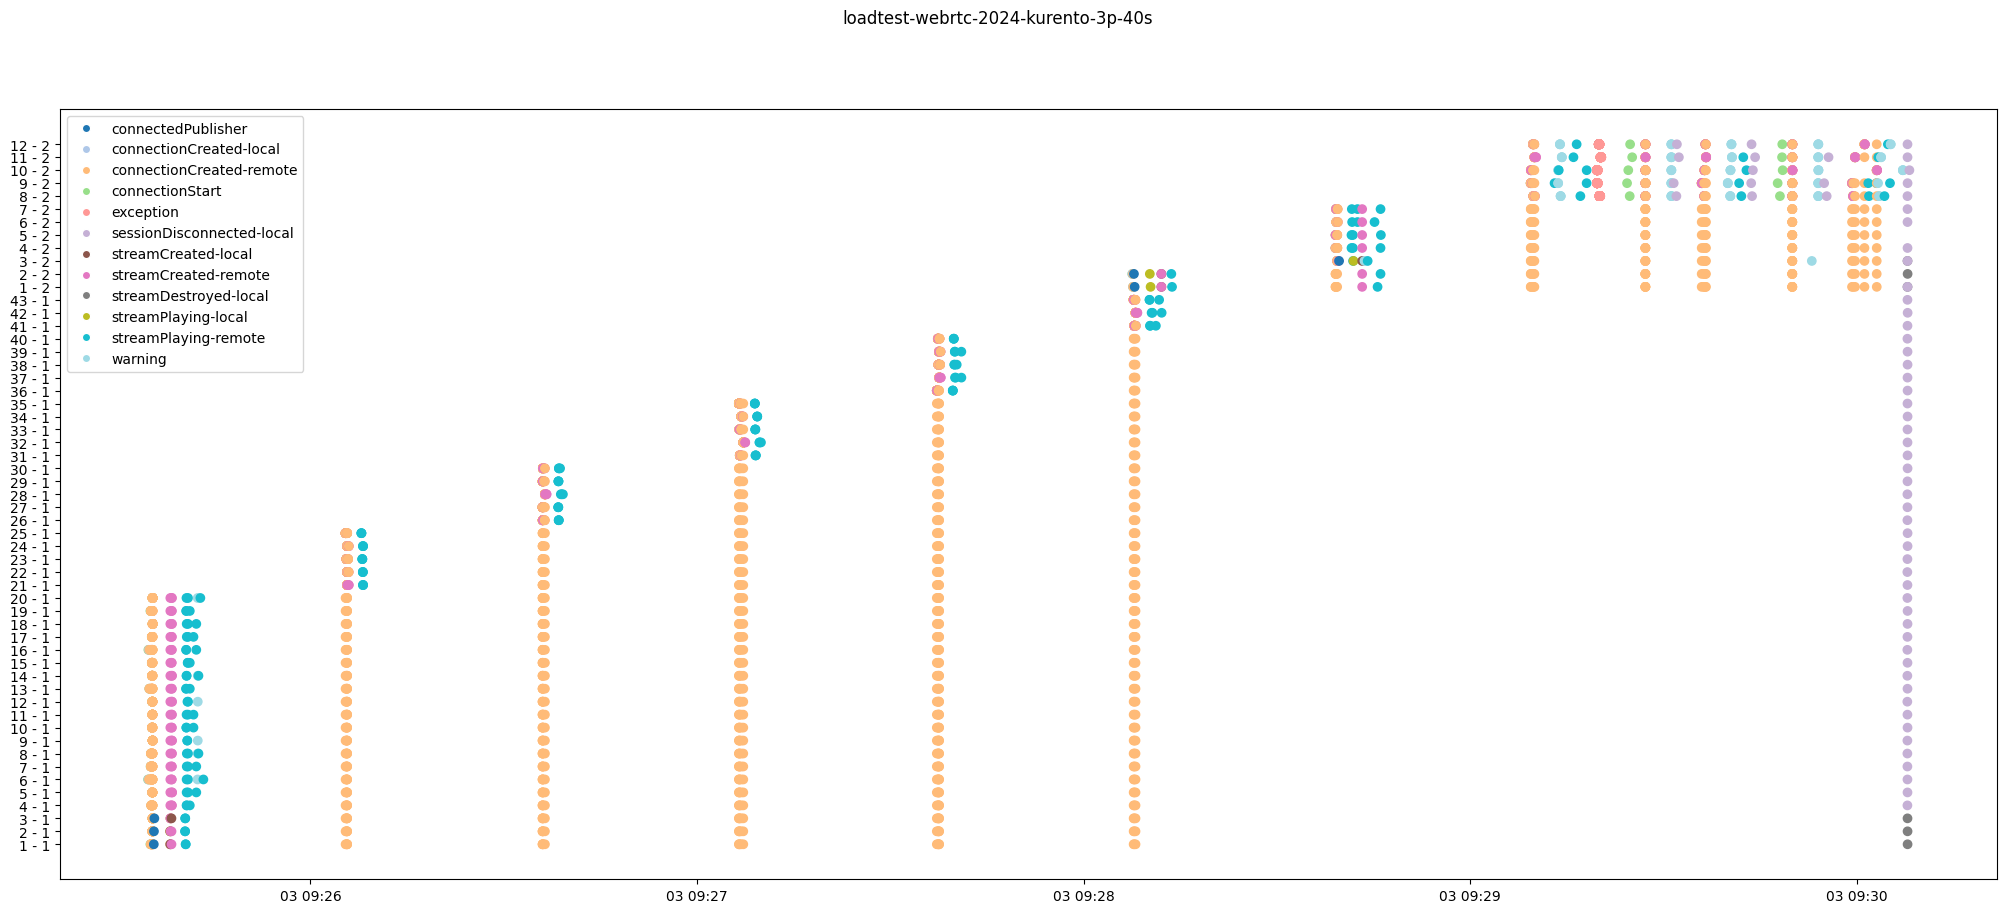

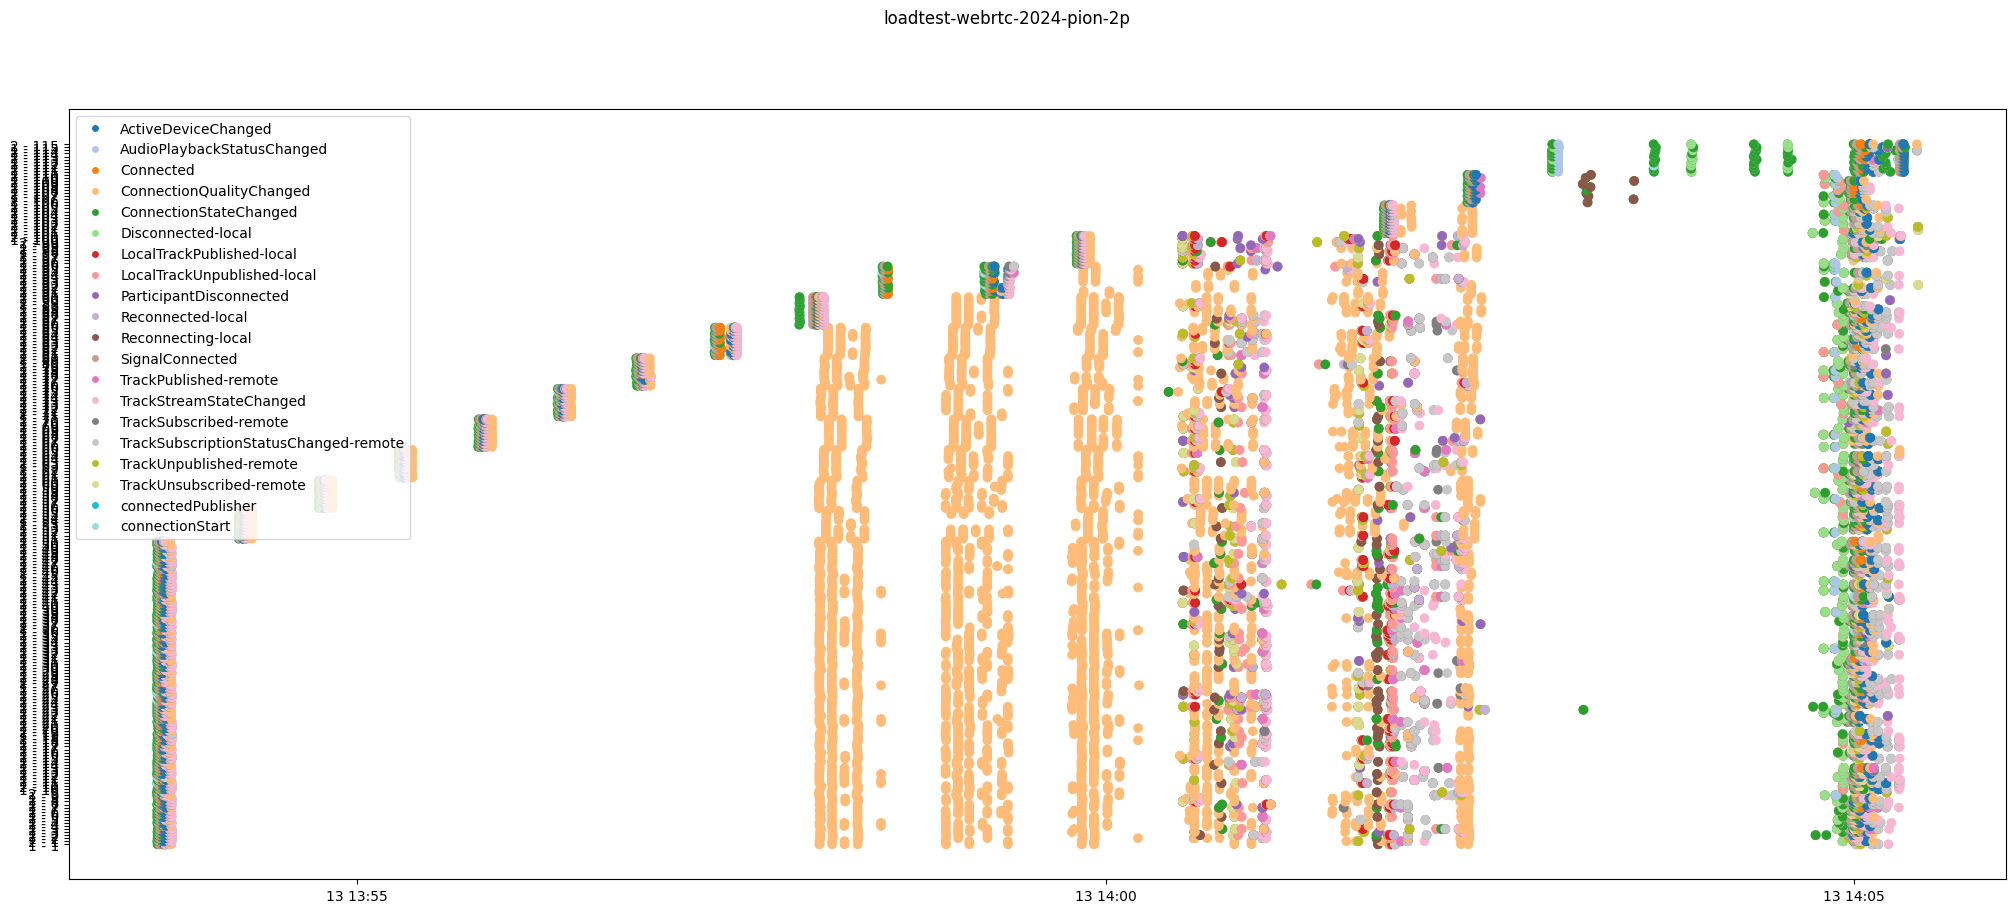

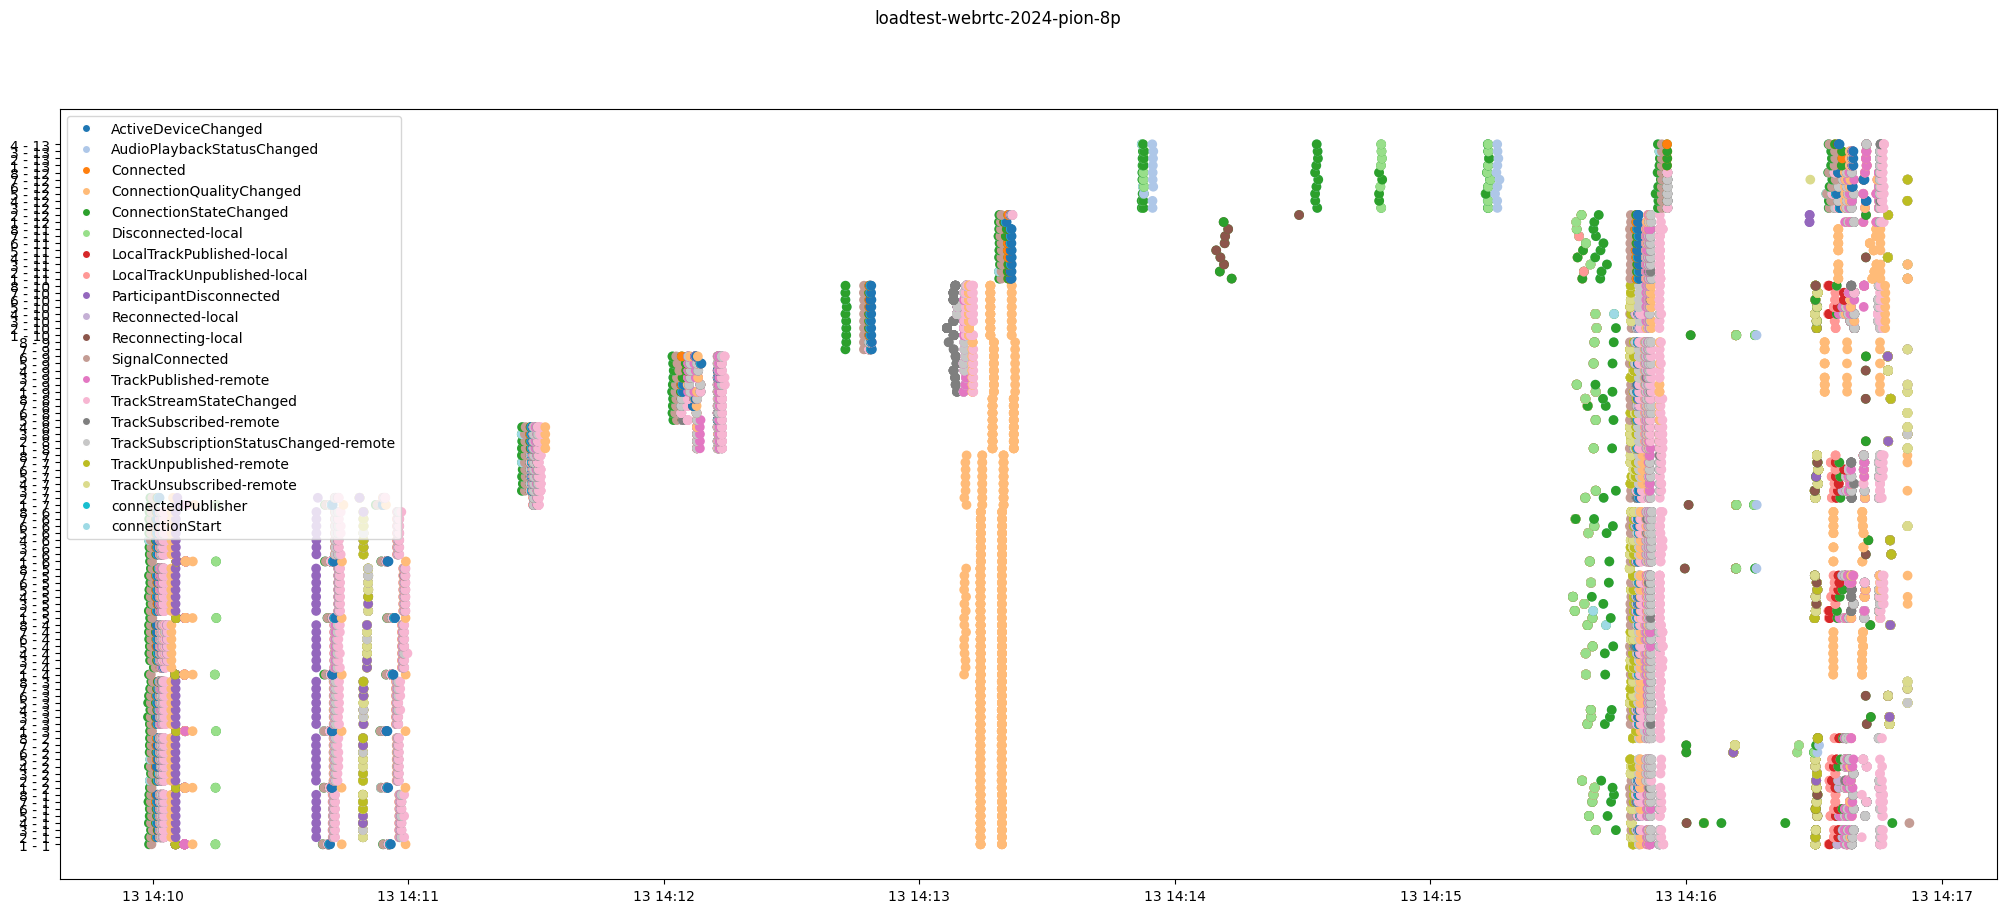

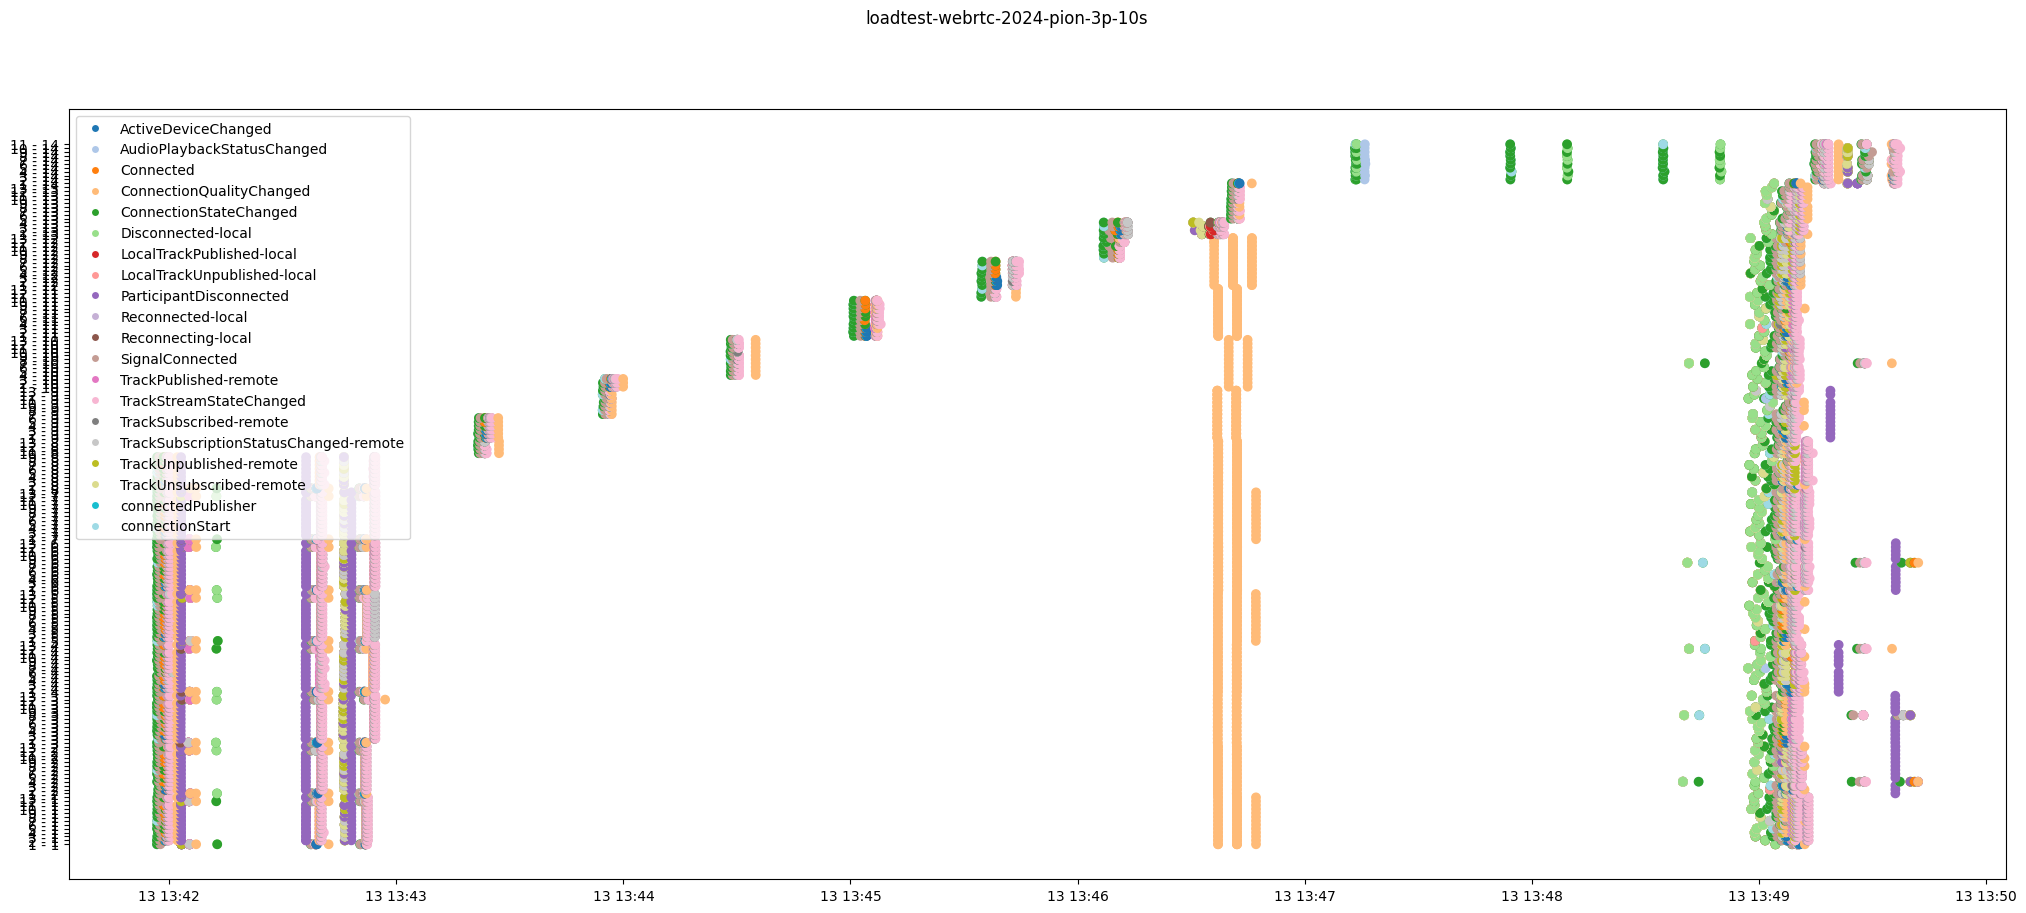

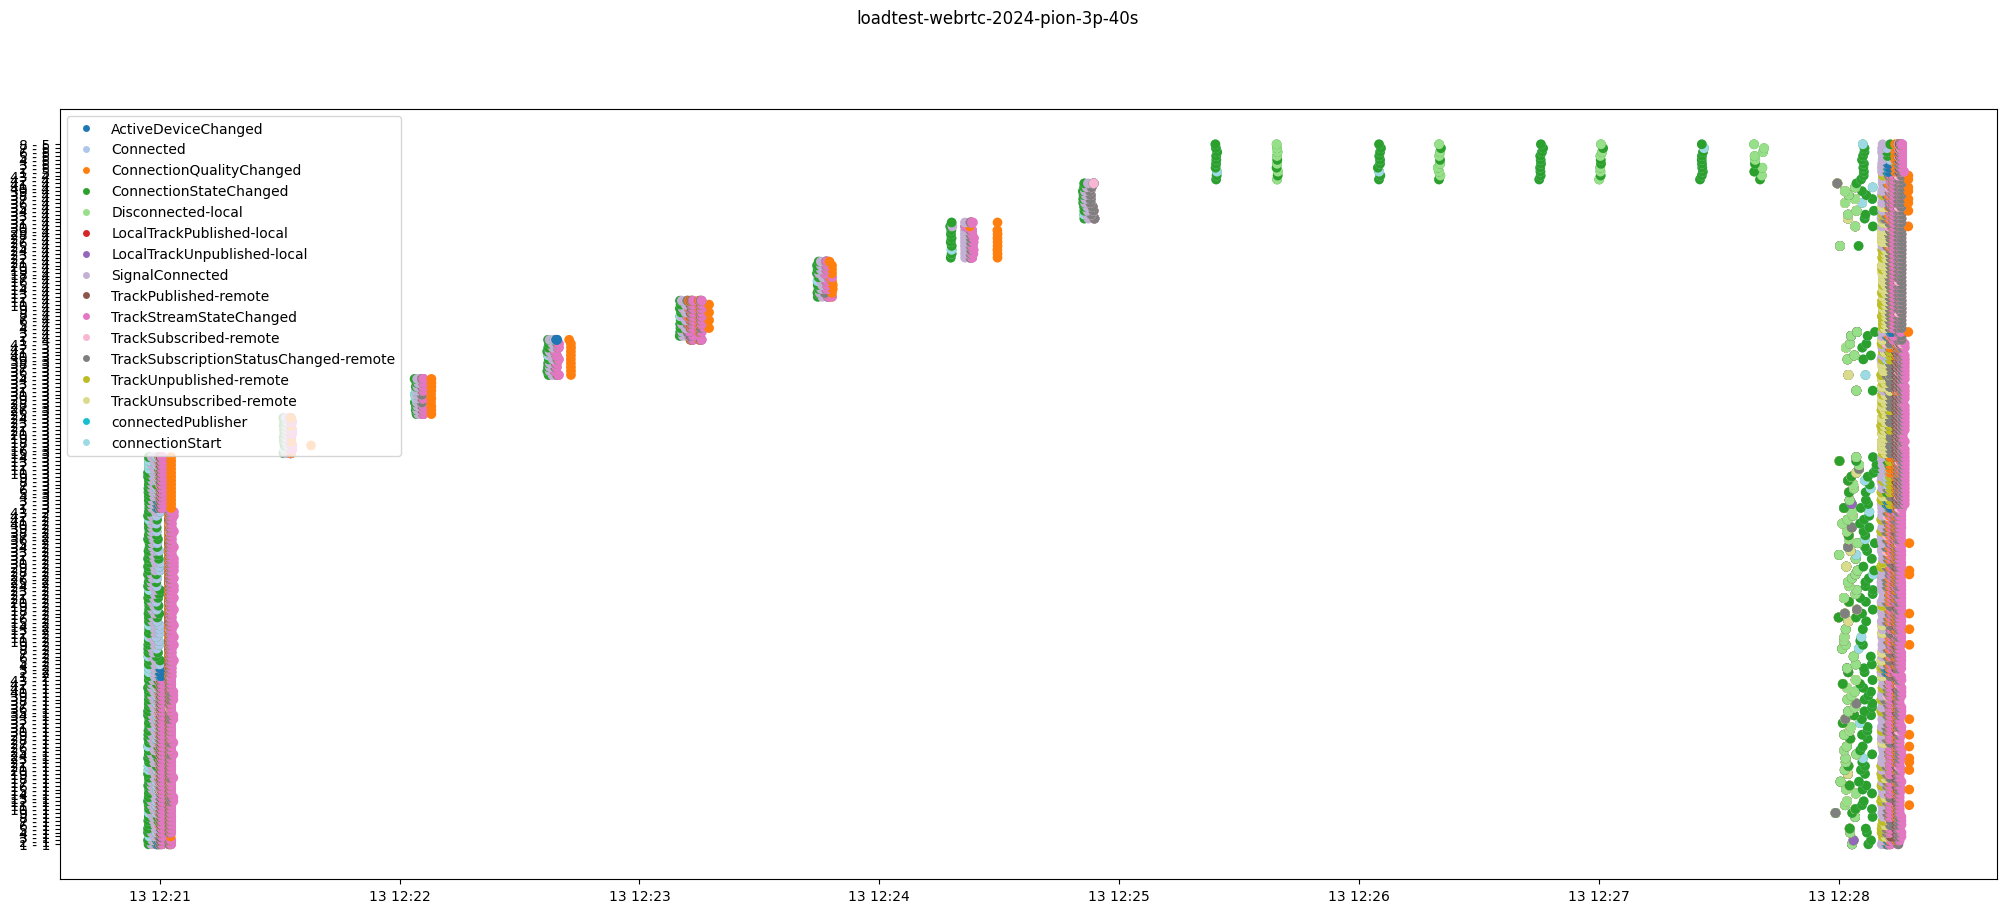

In [11]:
for test in events_dfs.keys():
    events_df = events_dfs[test]
    events_df = events_df.sort_values(by=["session", "user", "timestamp"])
    # events_df = events_df[
    #     (events_df['event'] == 'connectionStart') |
    #     # (events_df['event'] == 'signalConnected') |
    #     # (events_df['event'] == 'connectedPublisher') |
    #     ((events_df['event'] == 'streamCreated') & (events_df['connection'] == 'local')) |
    #     ((events_df['event'] == 'streamDestroyed') & (events_df['connection'] == 'local')) |
    #     (events_df['event'] == 'connectionEnd')
    # ]
    events_df = events_df[
        ~(events_df['event'] == 'publisherStartSpeaking-local') & ~(events_df['event'] == 'publisherStopSpeaking-local') &
        ~(events_df['event'] == 'accessAllowed-local')
    ]
    fig, ax = plt.subplots()
    event_types = events_df['event'].unique()
    event_types.sort()
    colors = mpl.colormaps.get_cmap('tab20')(np.linspace(0, 1, len(event_types)))
    event_color = dict(zip(event_types, colors))
    y_labels = []
    y_ticks = 0
    for session in events_df['session'].unique():
        events_df_session = events_df[events_df['session'] == session]
        for user in events_df_session['user'].unique():
            events_df_user = events_df_session[events_df_session['user'] == user]
            y_ticks += 1
            y_pos = [y_ticks] * len(events_df_user)
            ax.scatter(events_df_user['timestamp'], y_pos, c=[event_color[event] for event in events_df_user['event']])
            y_labels.append(f'{user} - {session}')


    # add legend
    legend_labels = []
    for event, color in event_color.items():
        legend_labels.append(plt.Line2D([0], [0], marker='o', color='w', label=event, markerfacecolor=color))
    ax.legend(handles=legend_labels, loc='upper left')
    fig.suptitle(f'{test}')
    # y labels should be user - session
    ax.set_yticks(range(1, y_ticks + 1))
    ax.set_yticklabels(y_labels)

In [12]:
df_cpu_list = []
for index in index_list_names:
    df_cpu = pd.read_csv(f"dfs_final/{index}-medianode.csv")
    df_cpu = df_cpu.drop(columns=["memory"]).dropna()
    df_cpu["@timestamp"] = pd.to_datetime(df_cpu["@timestamp"], format="ISO8601")
    df_cpu_list.append(df_cpu)

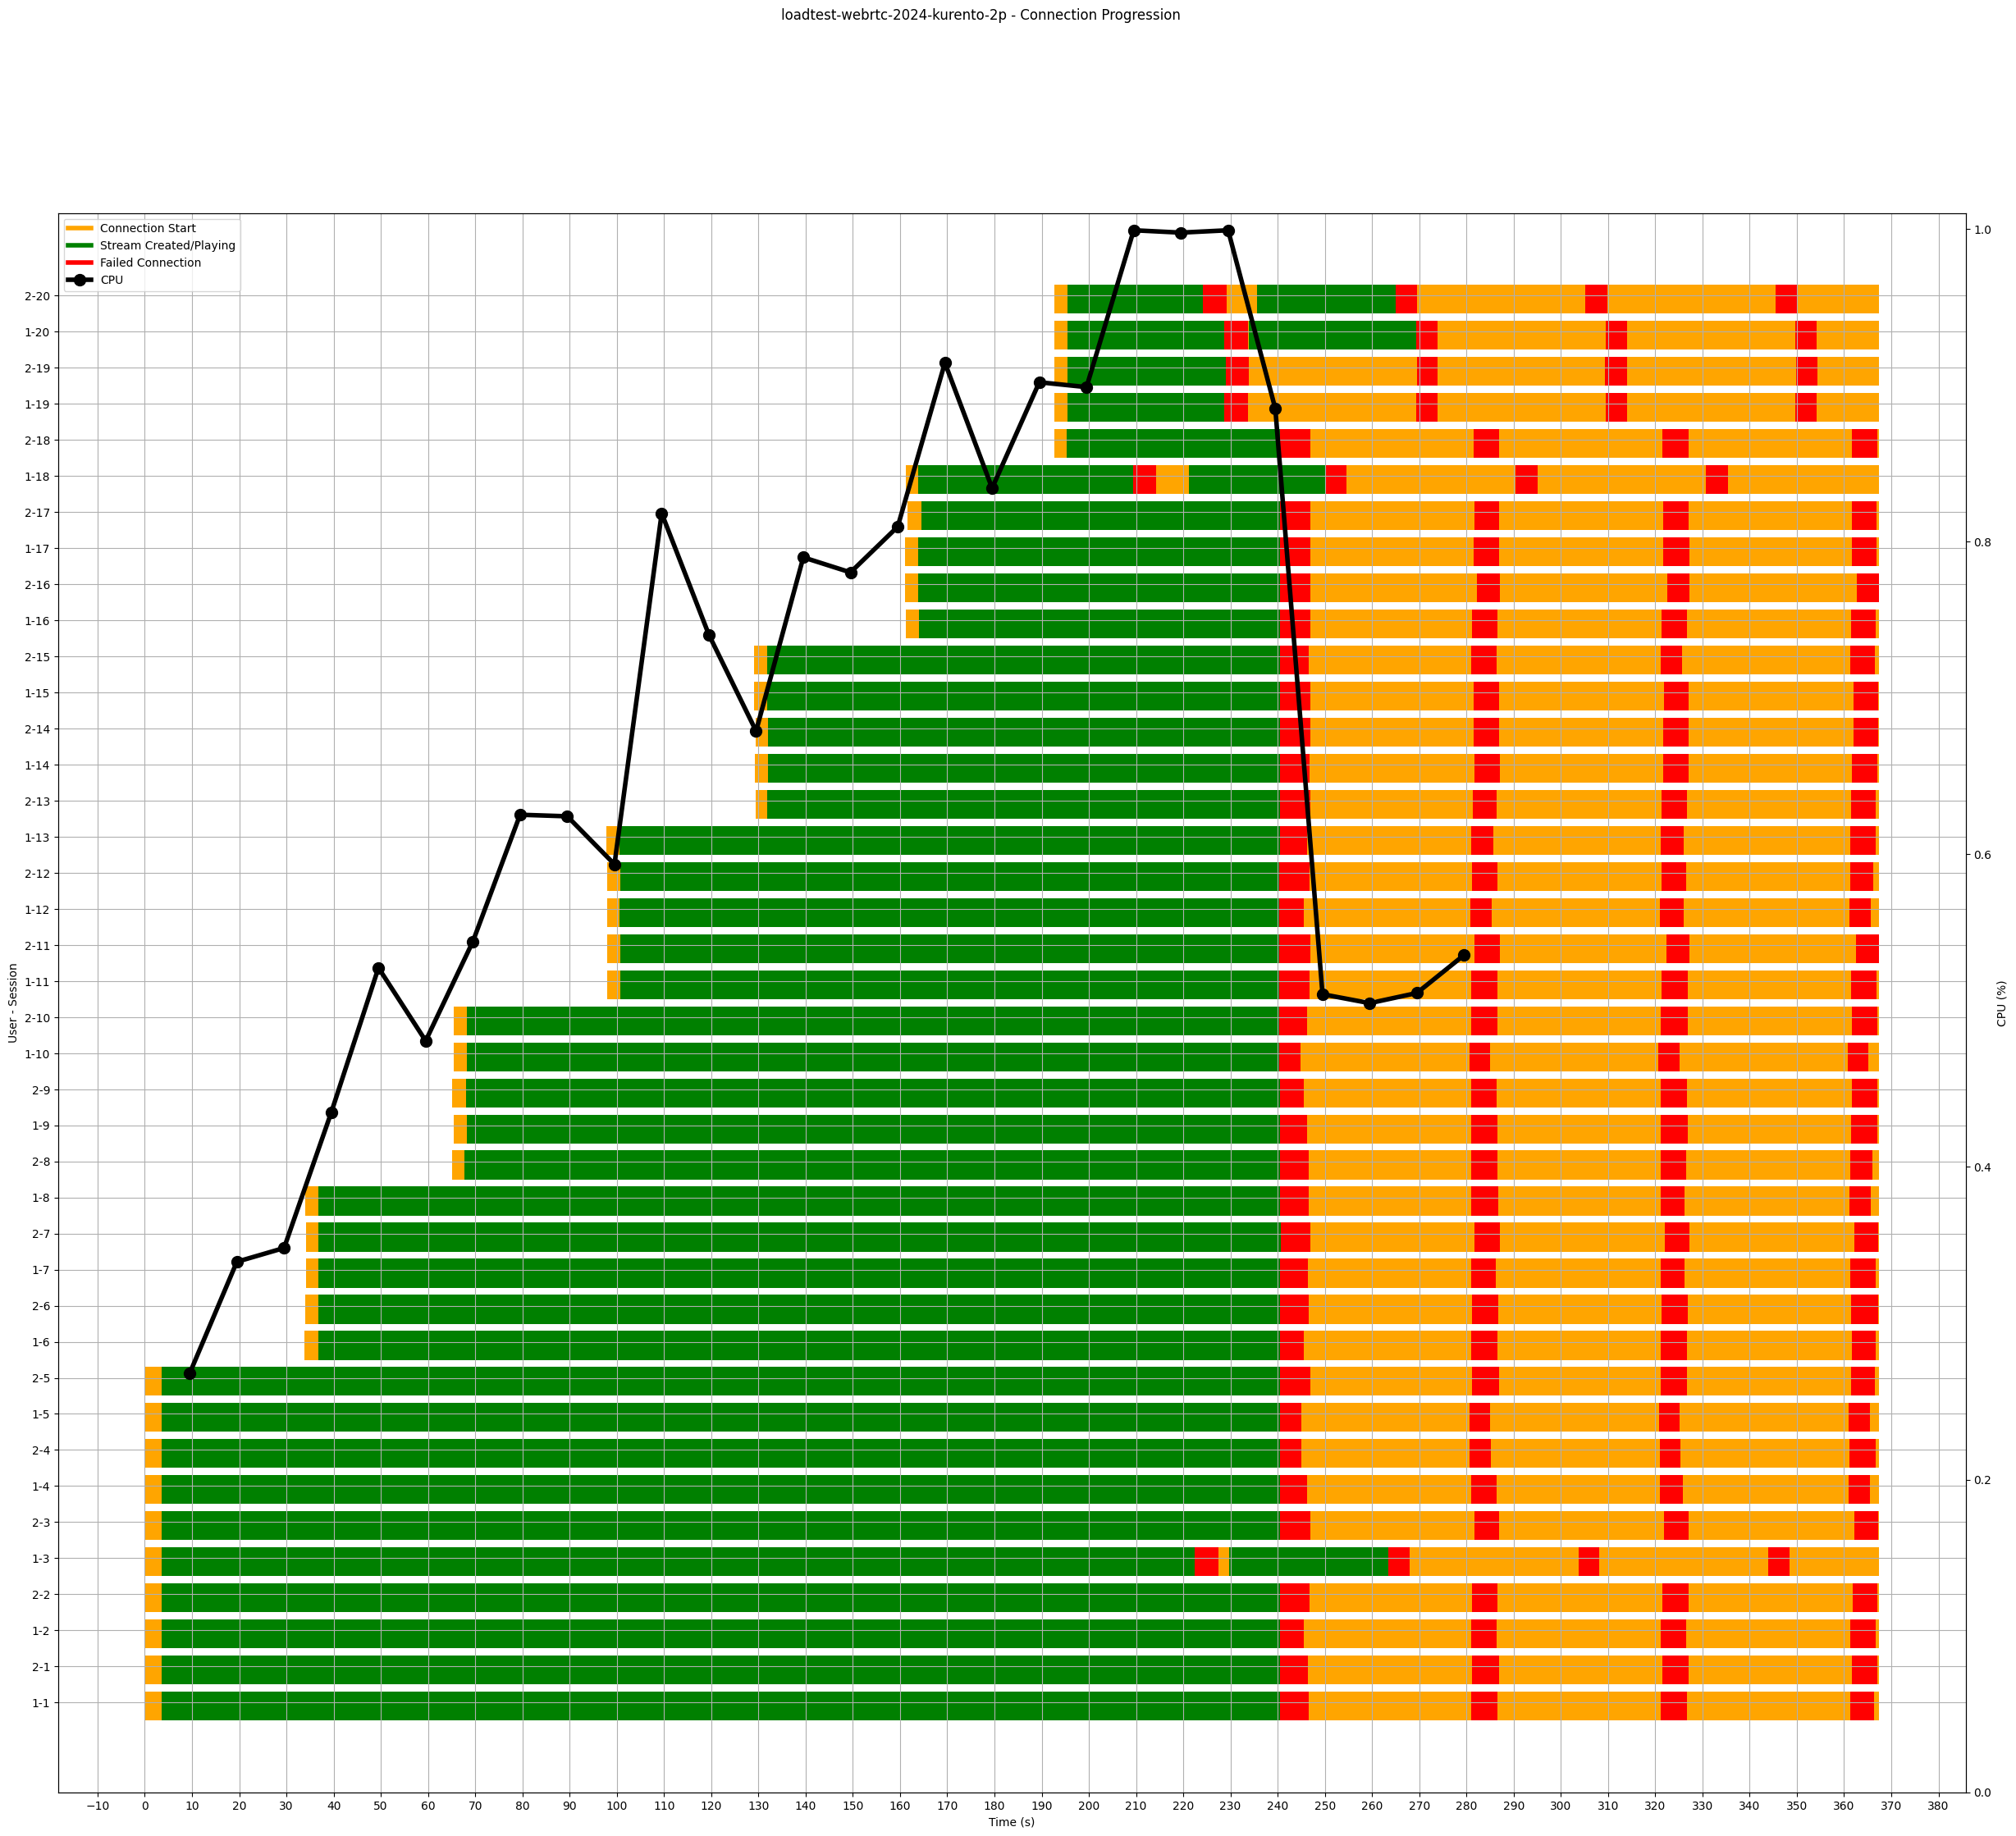

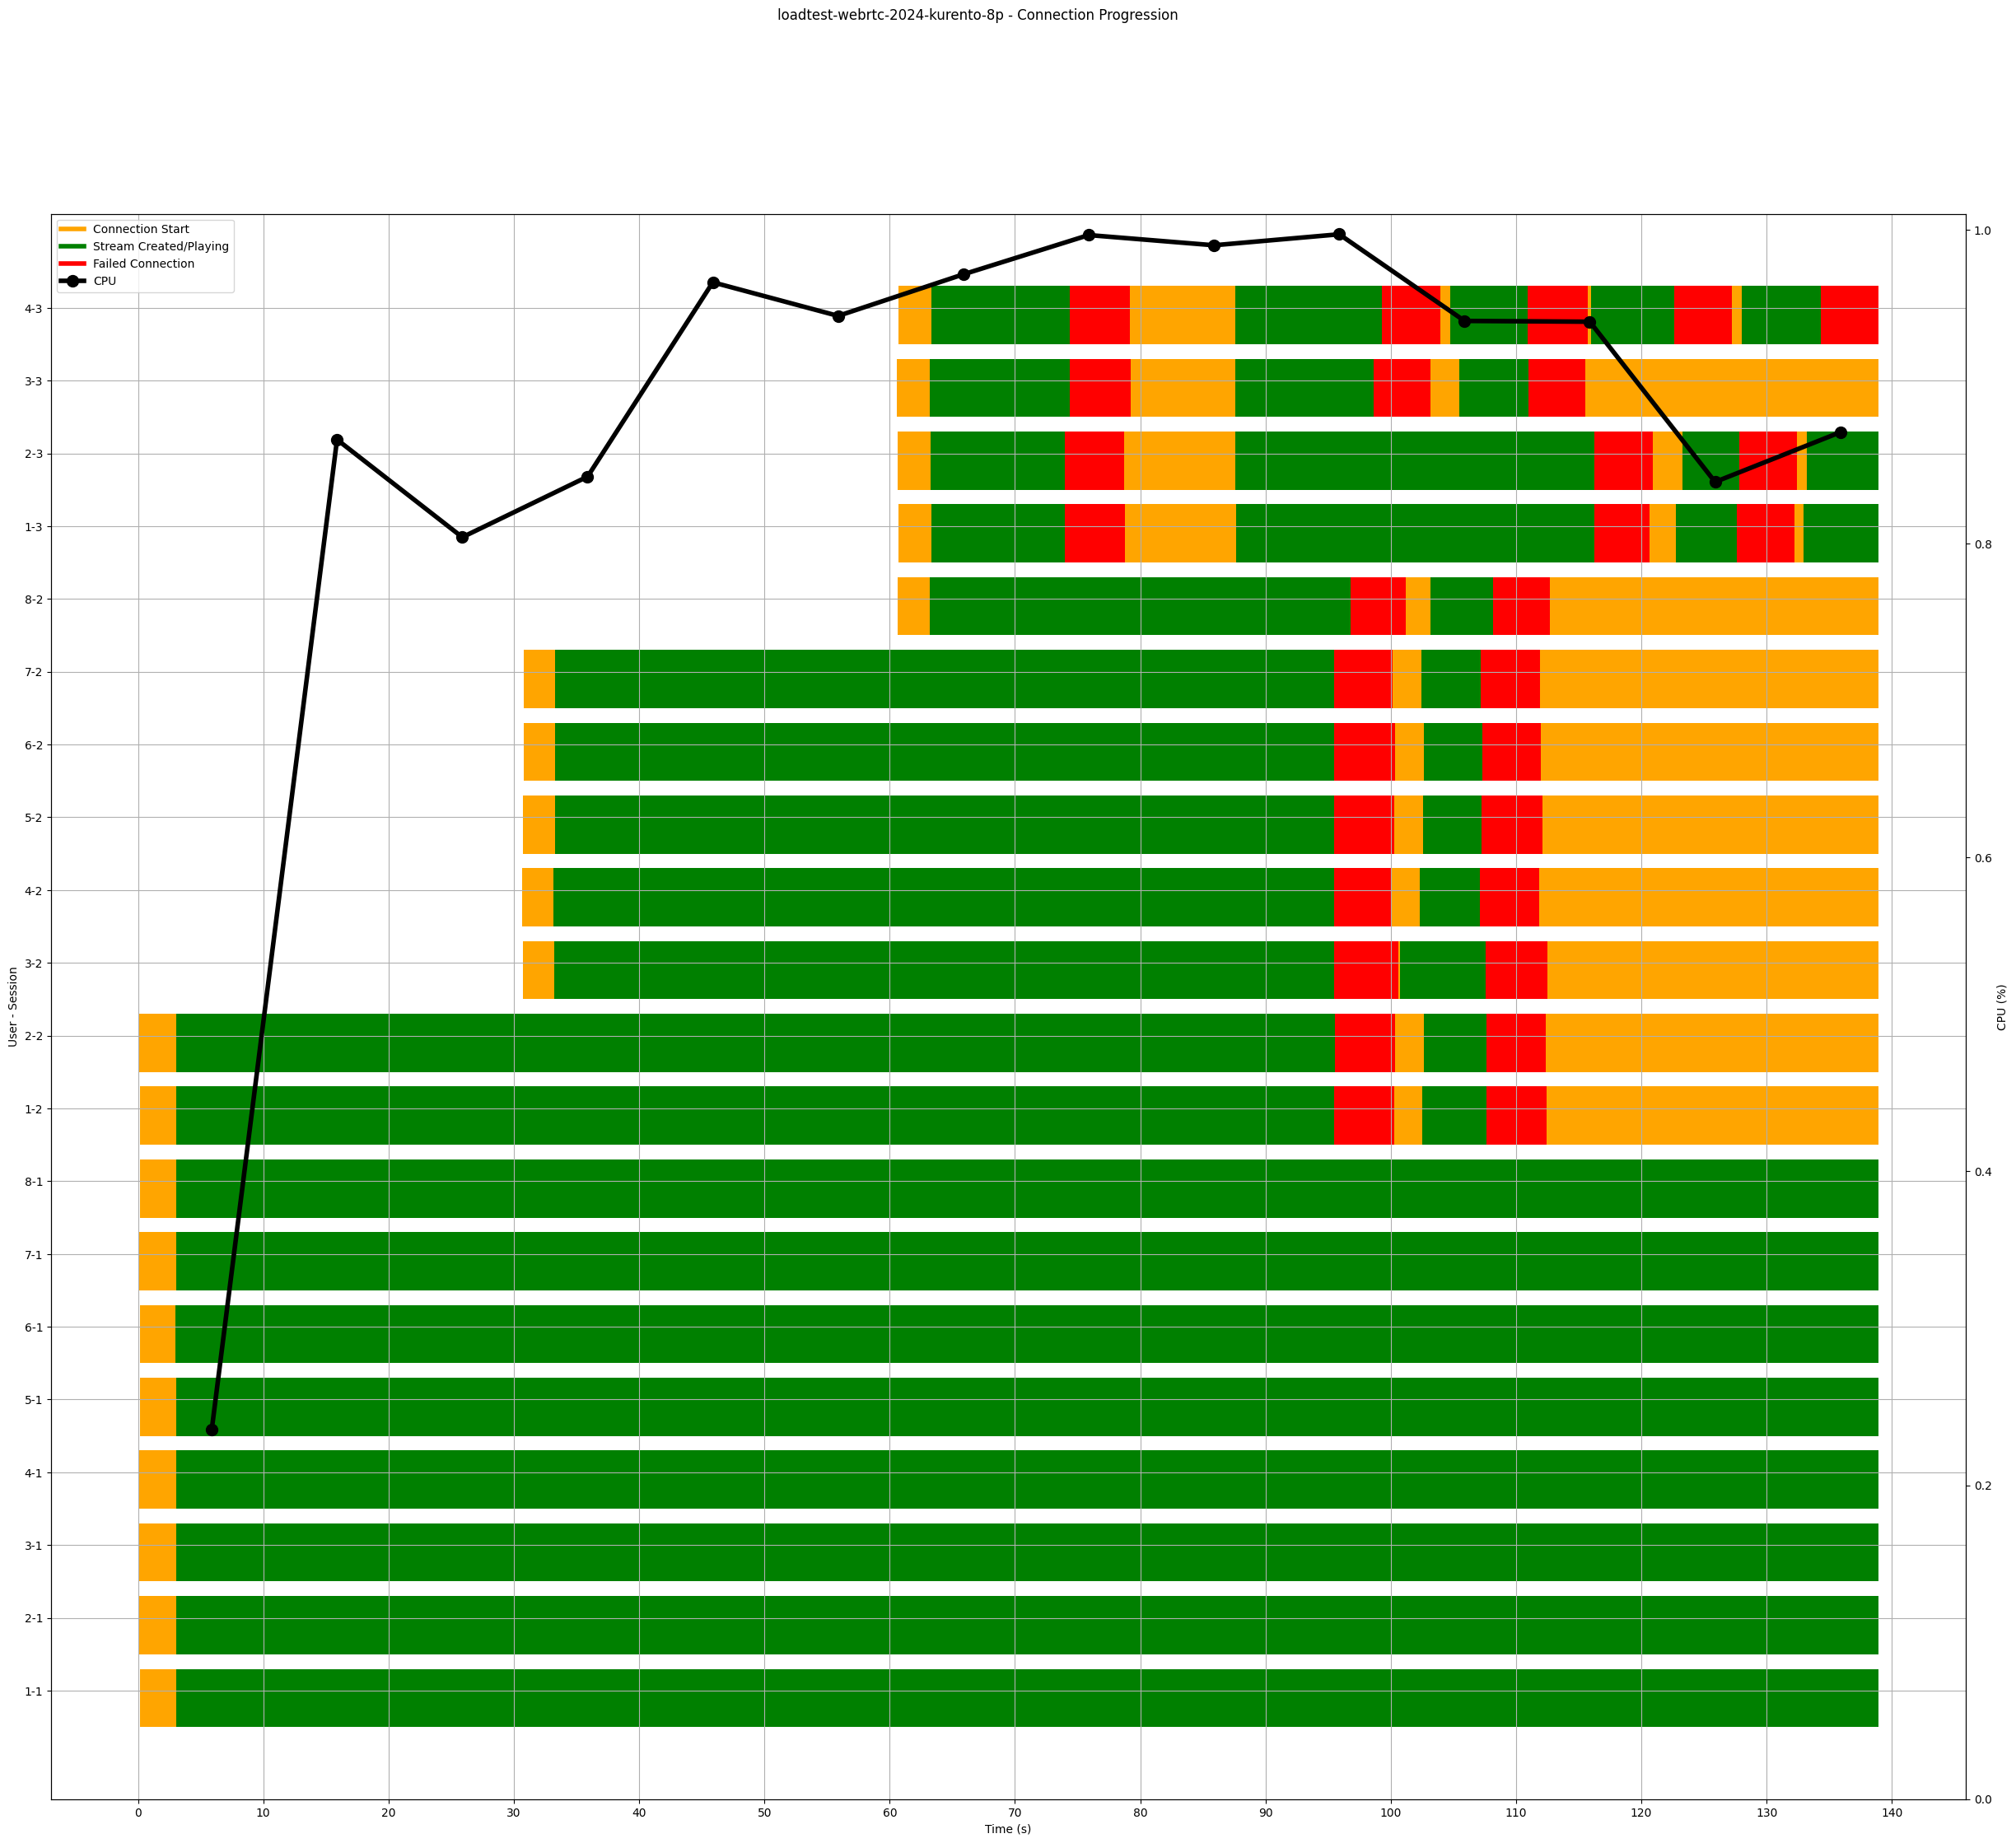

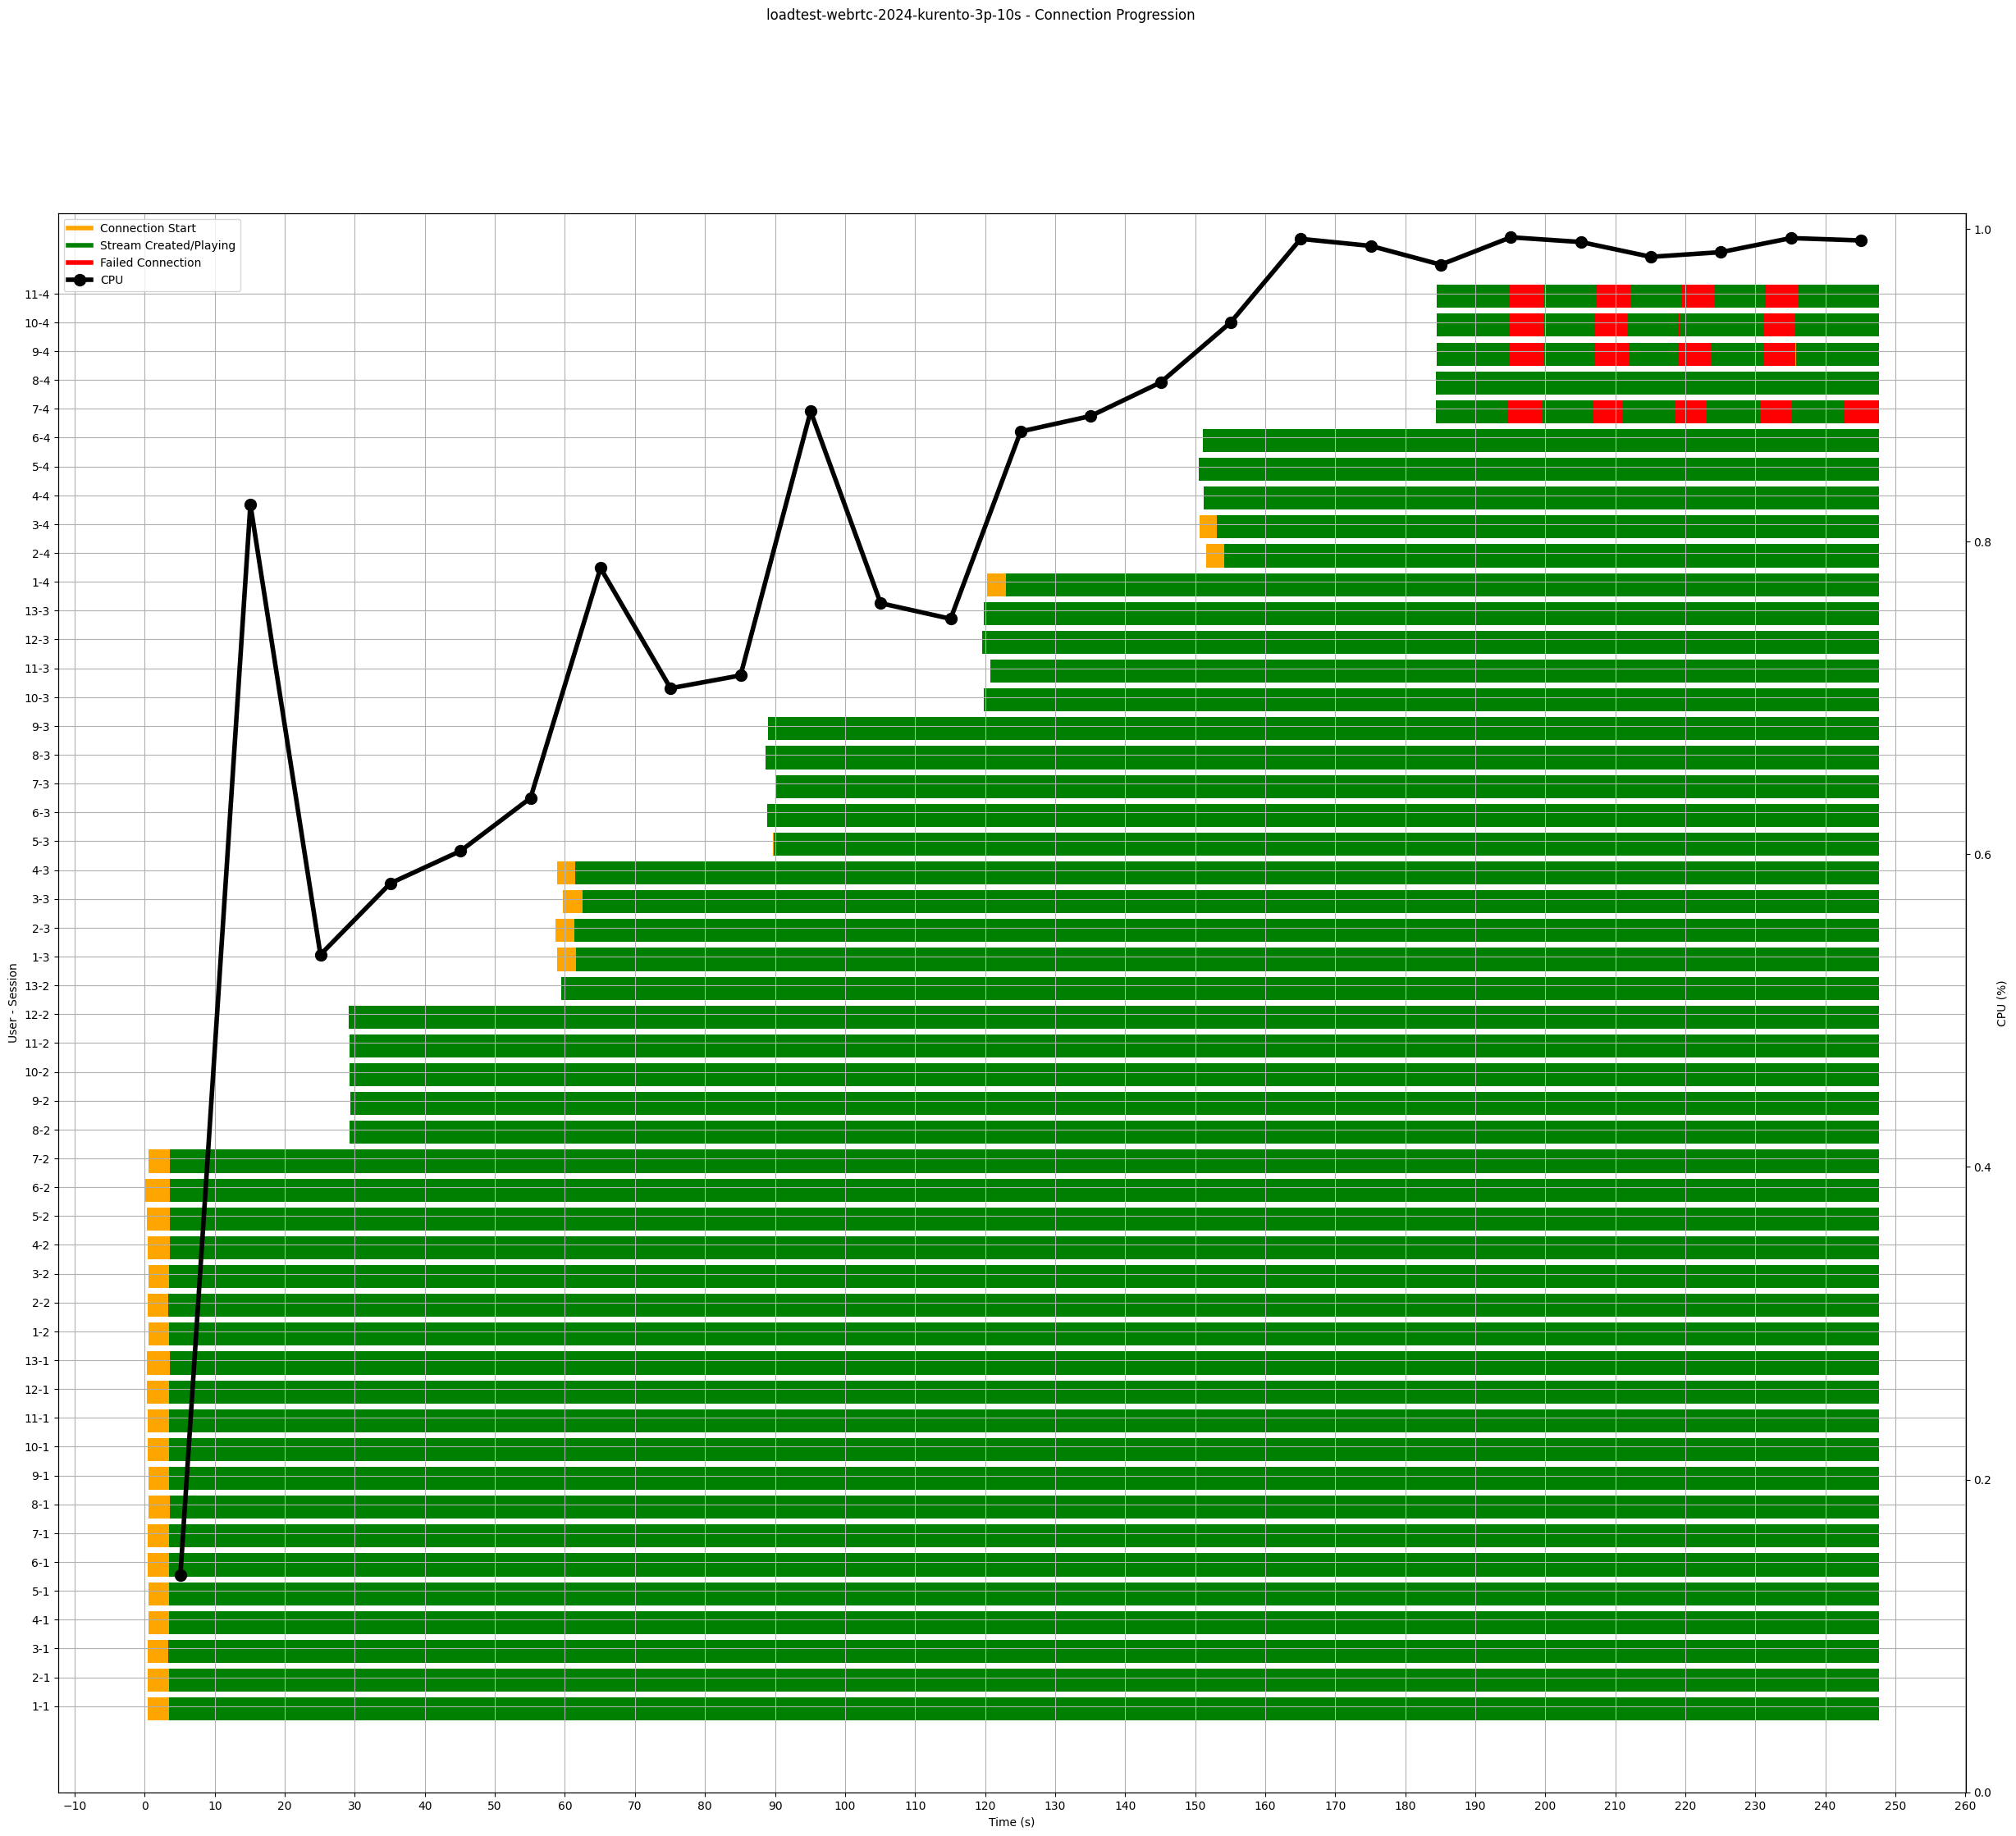

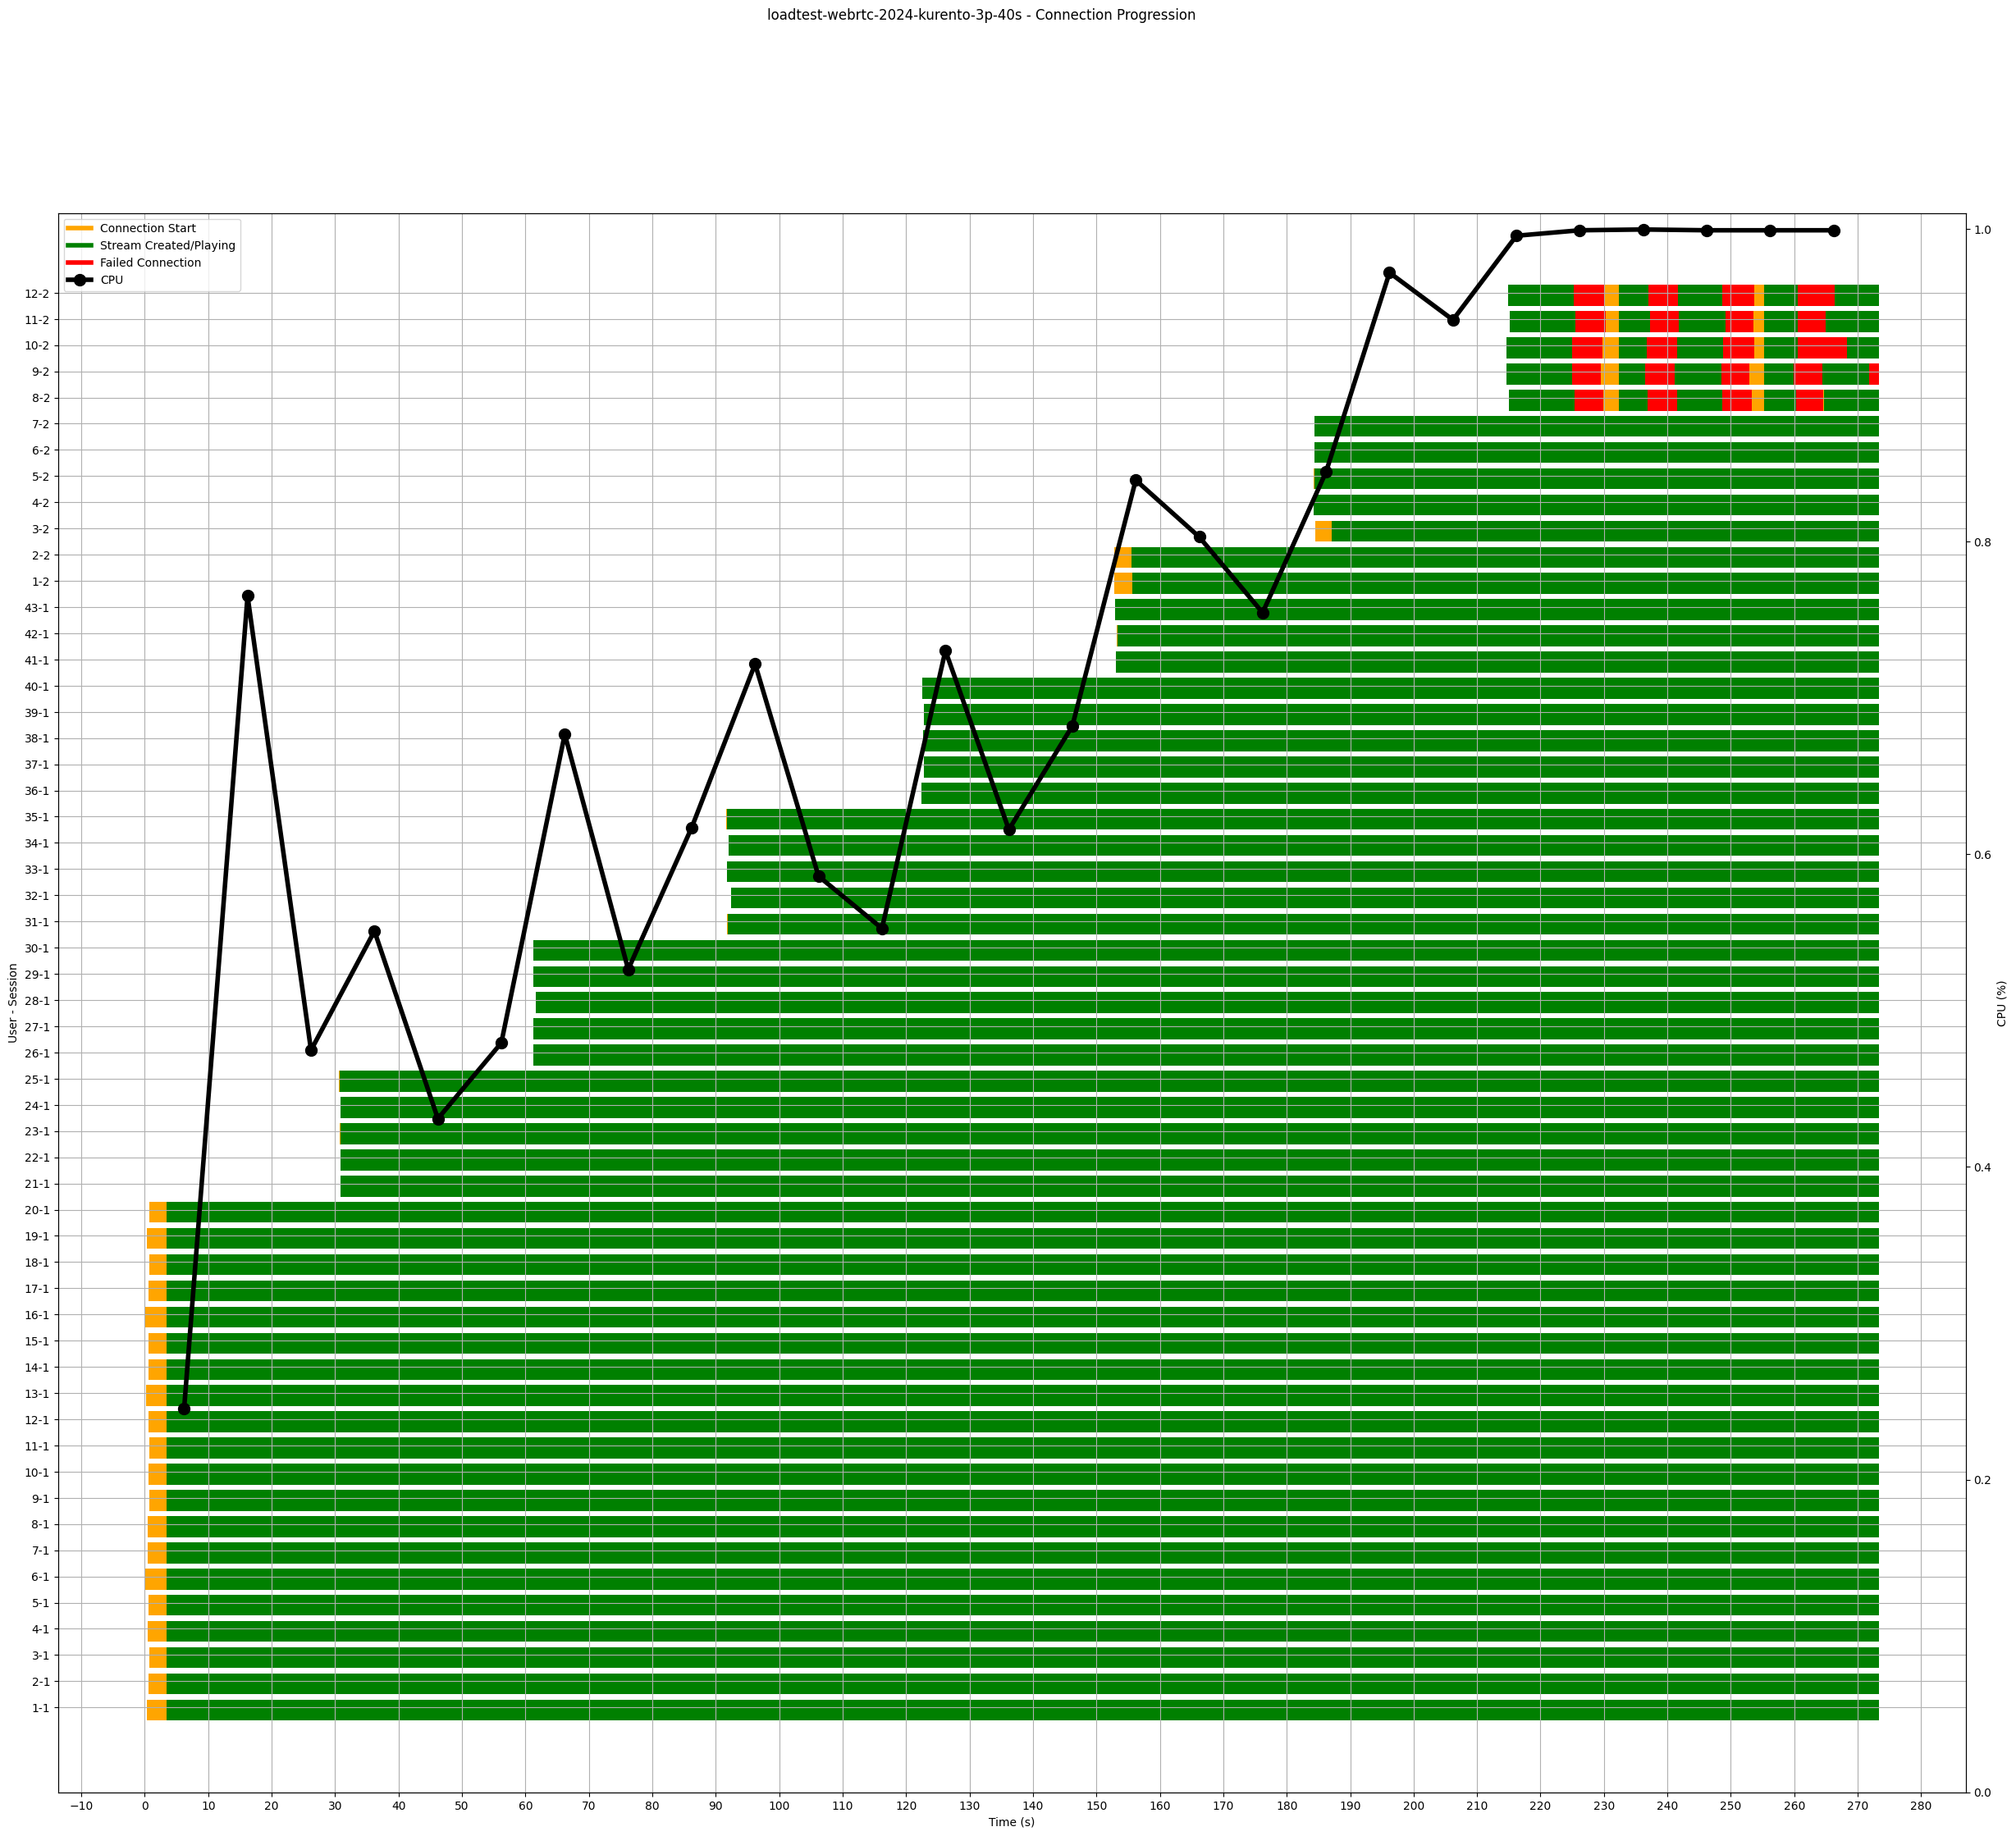

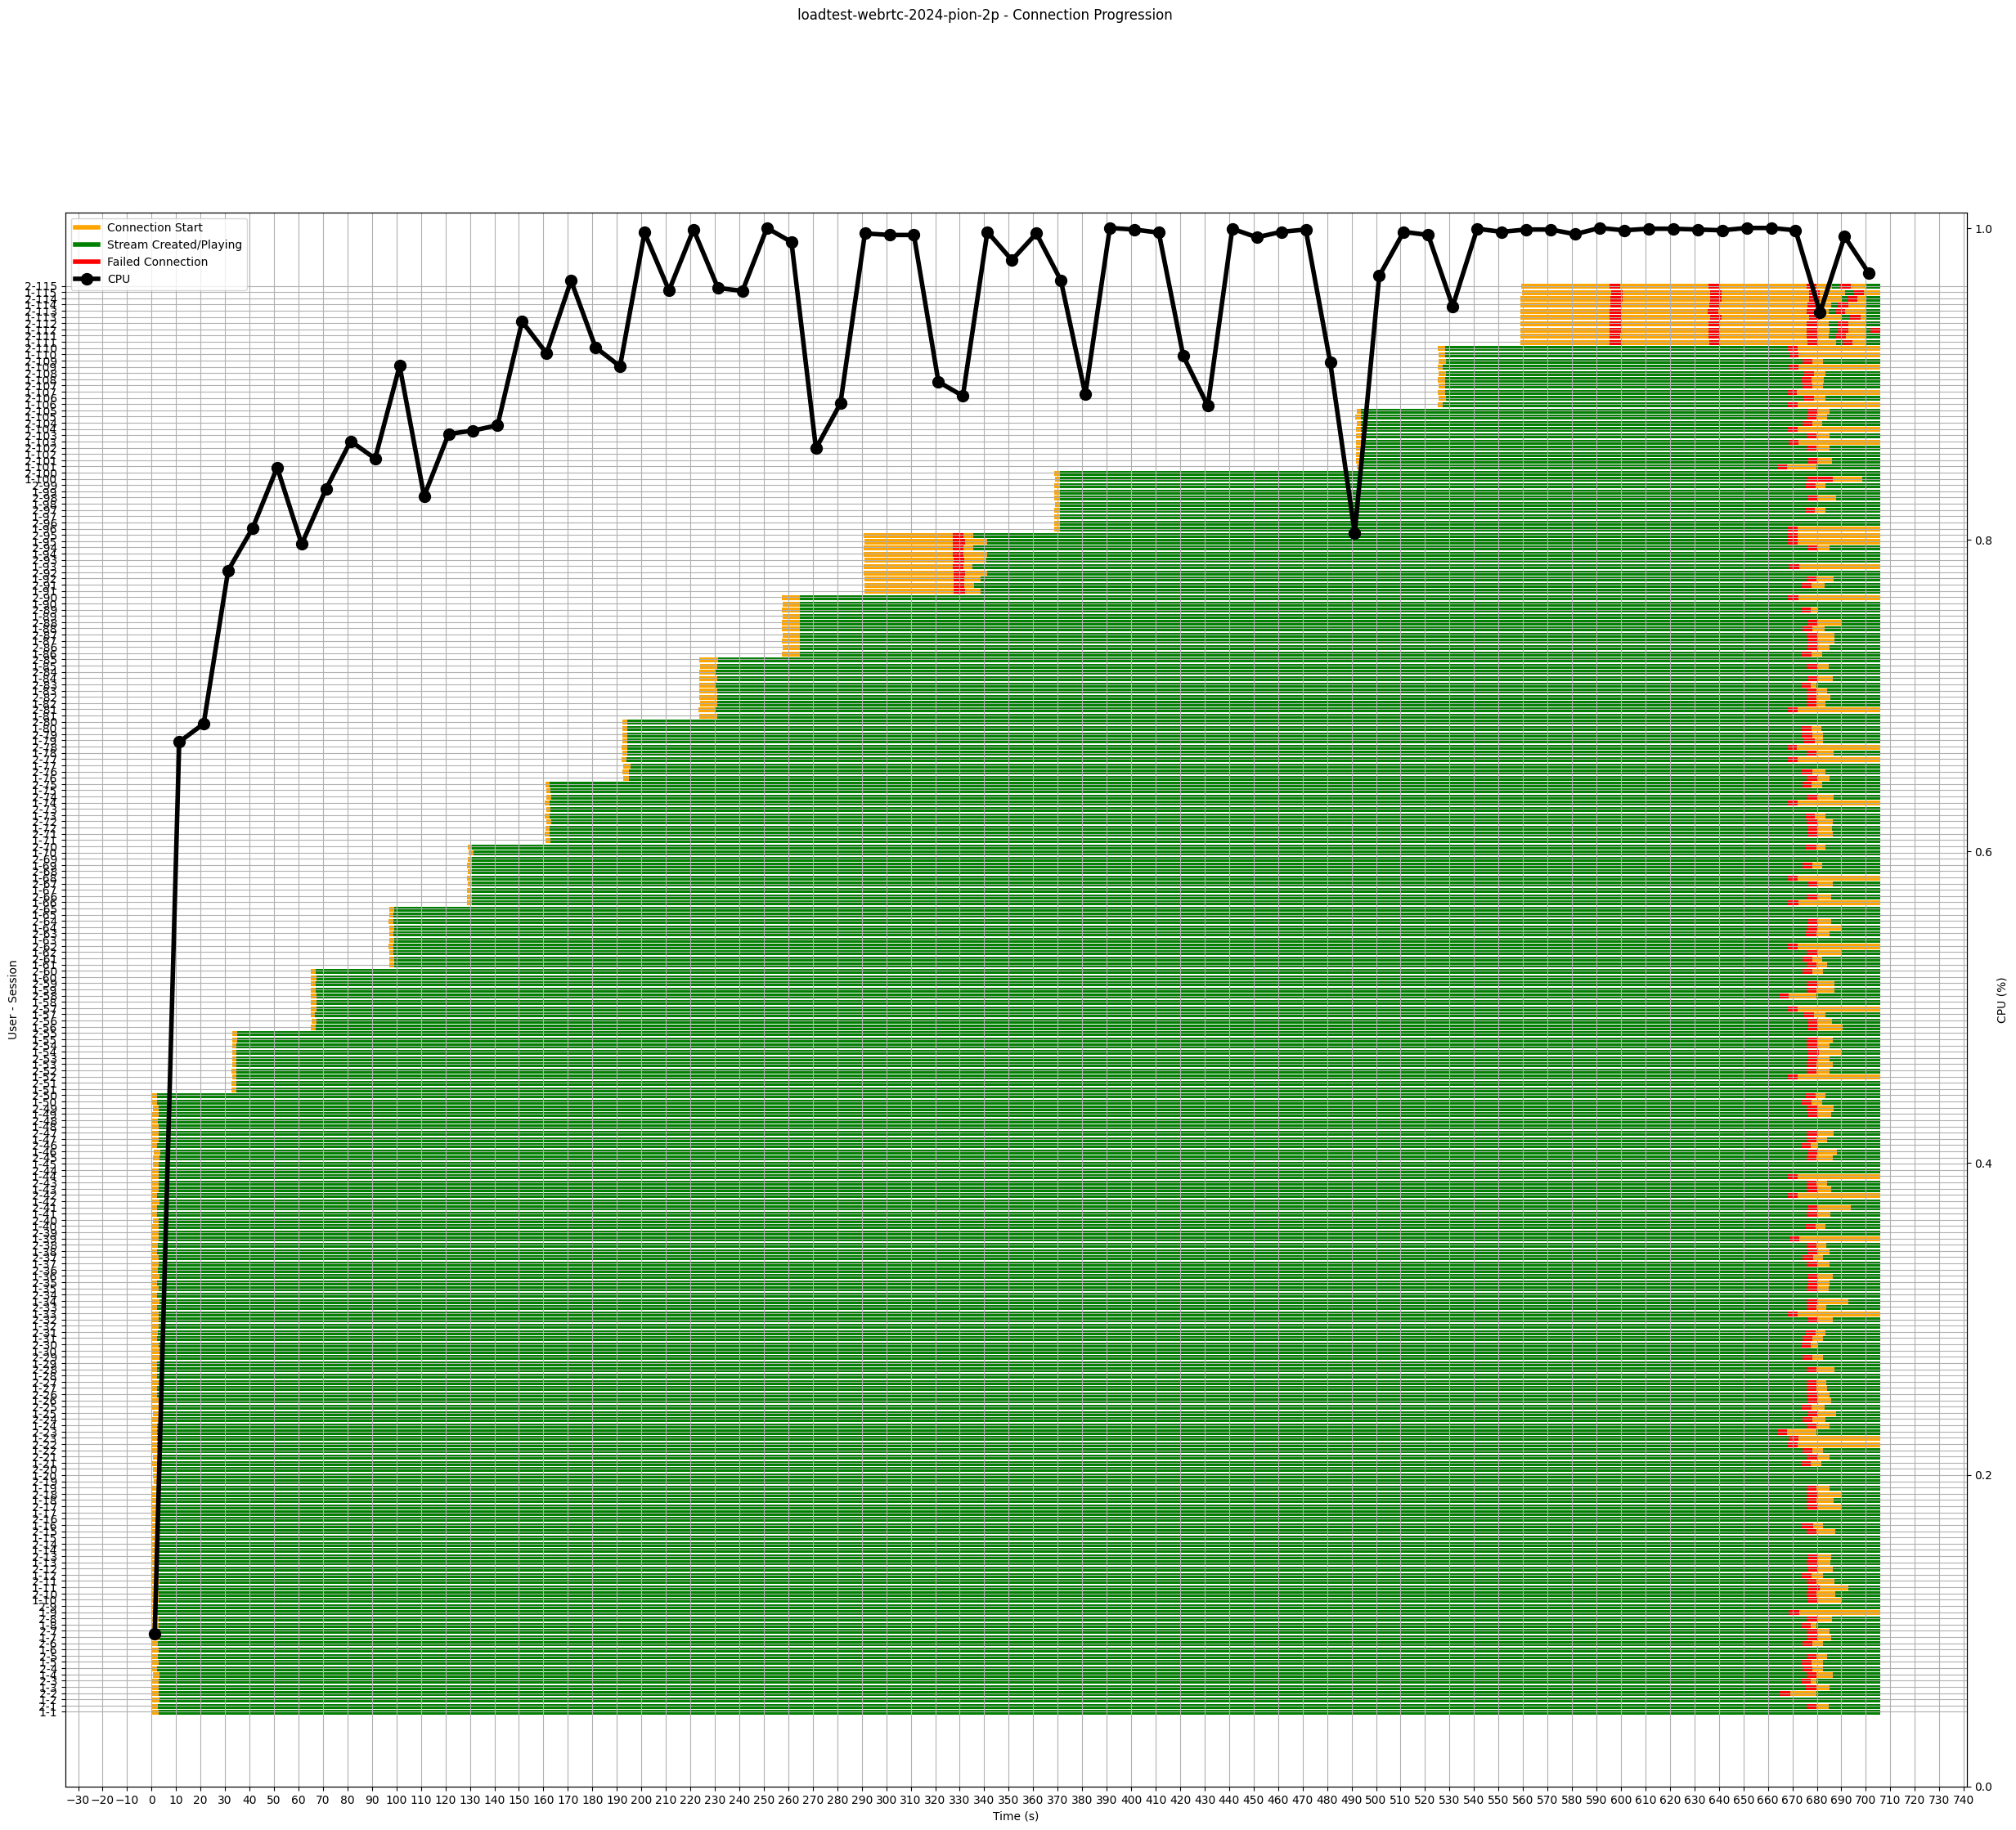

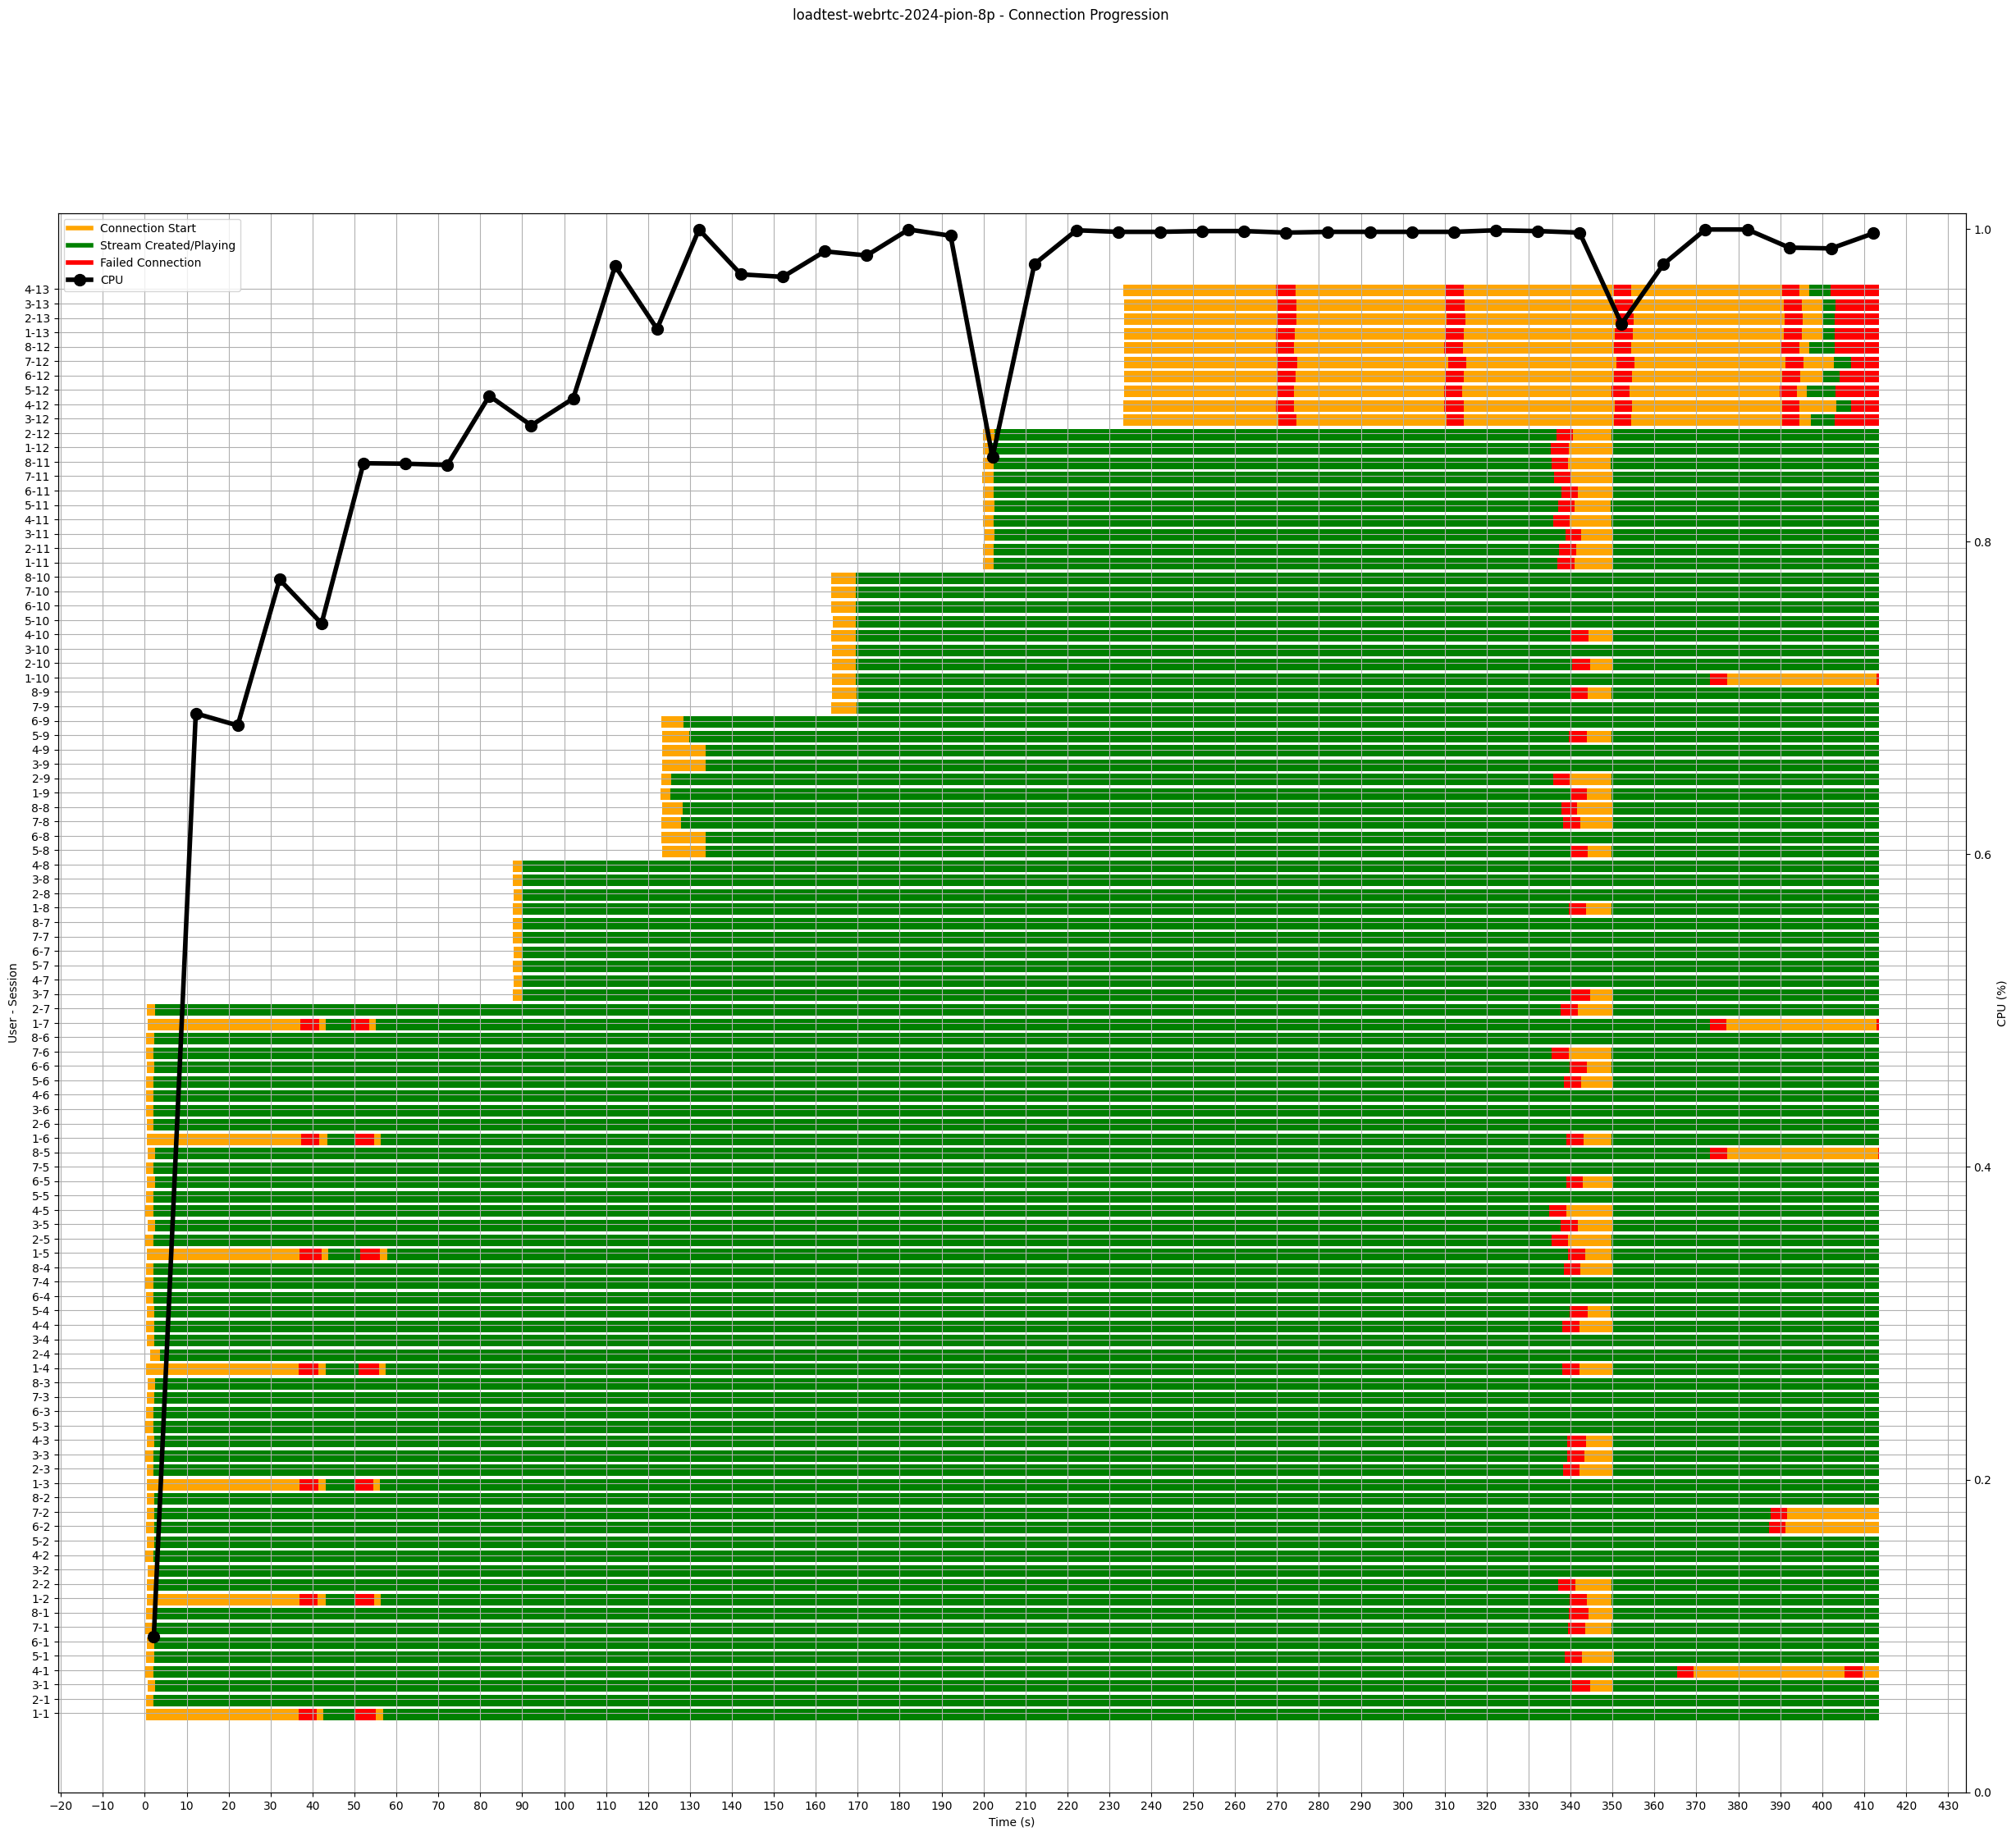

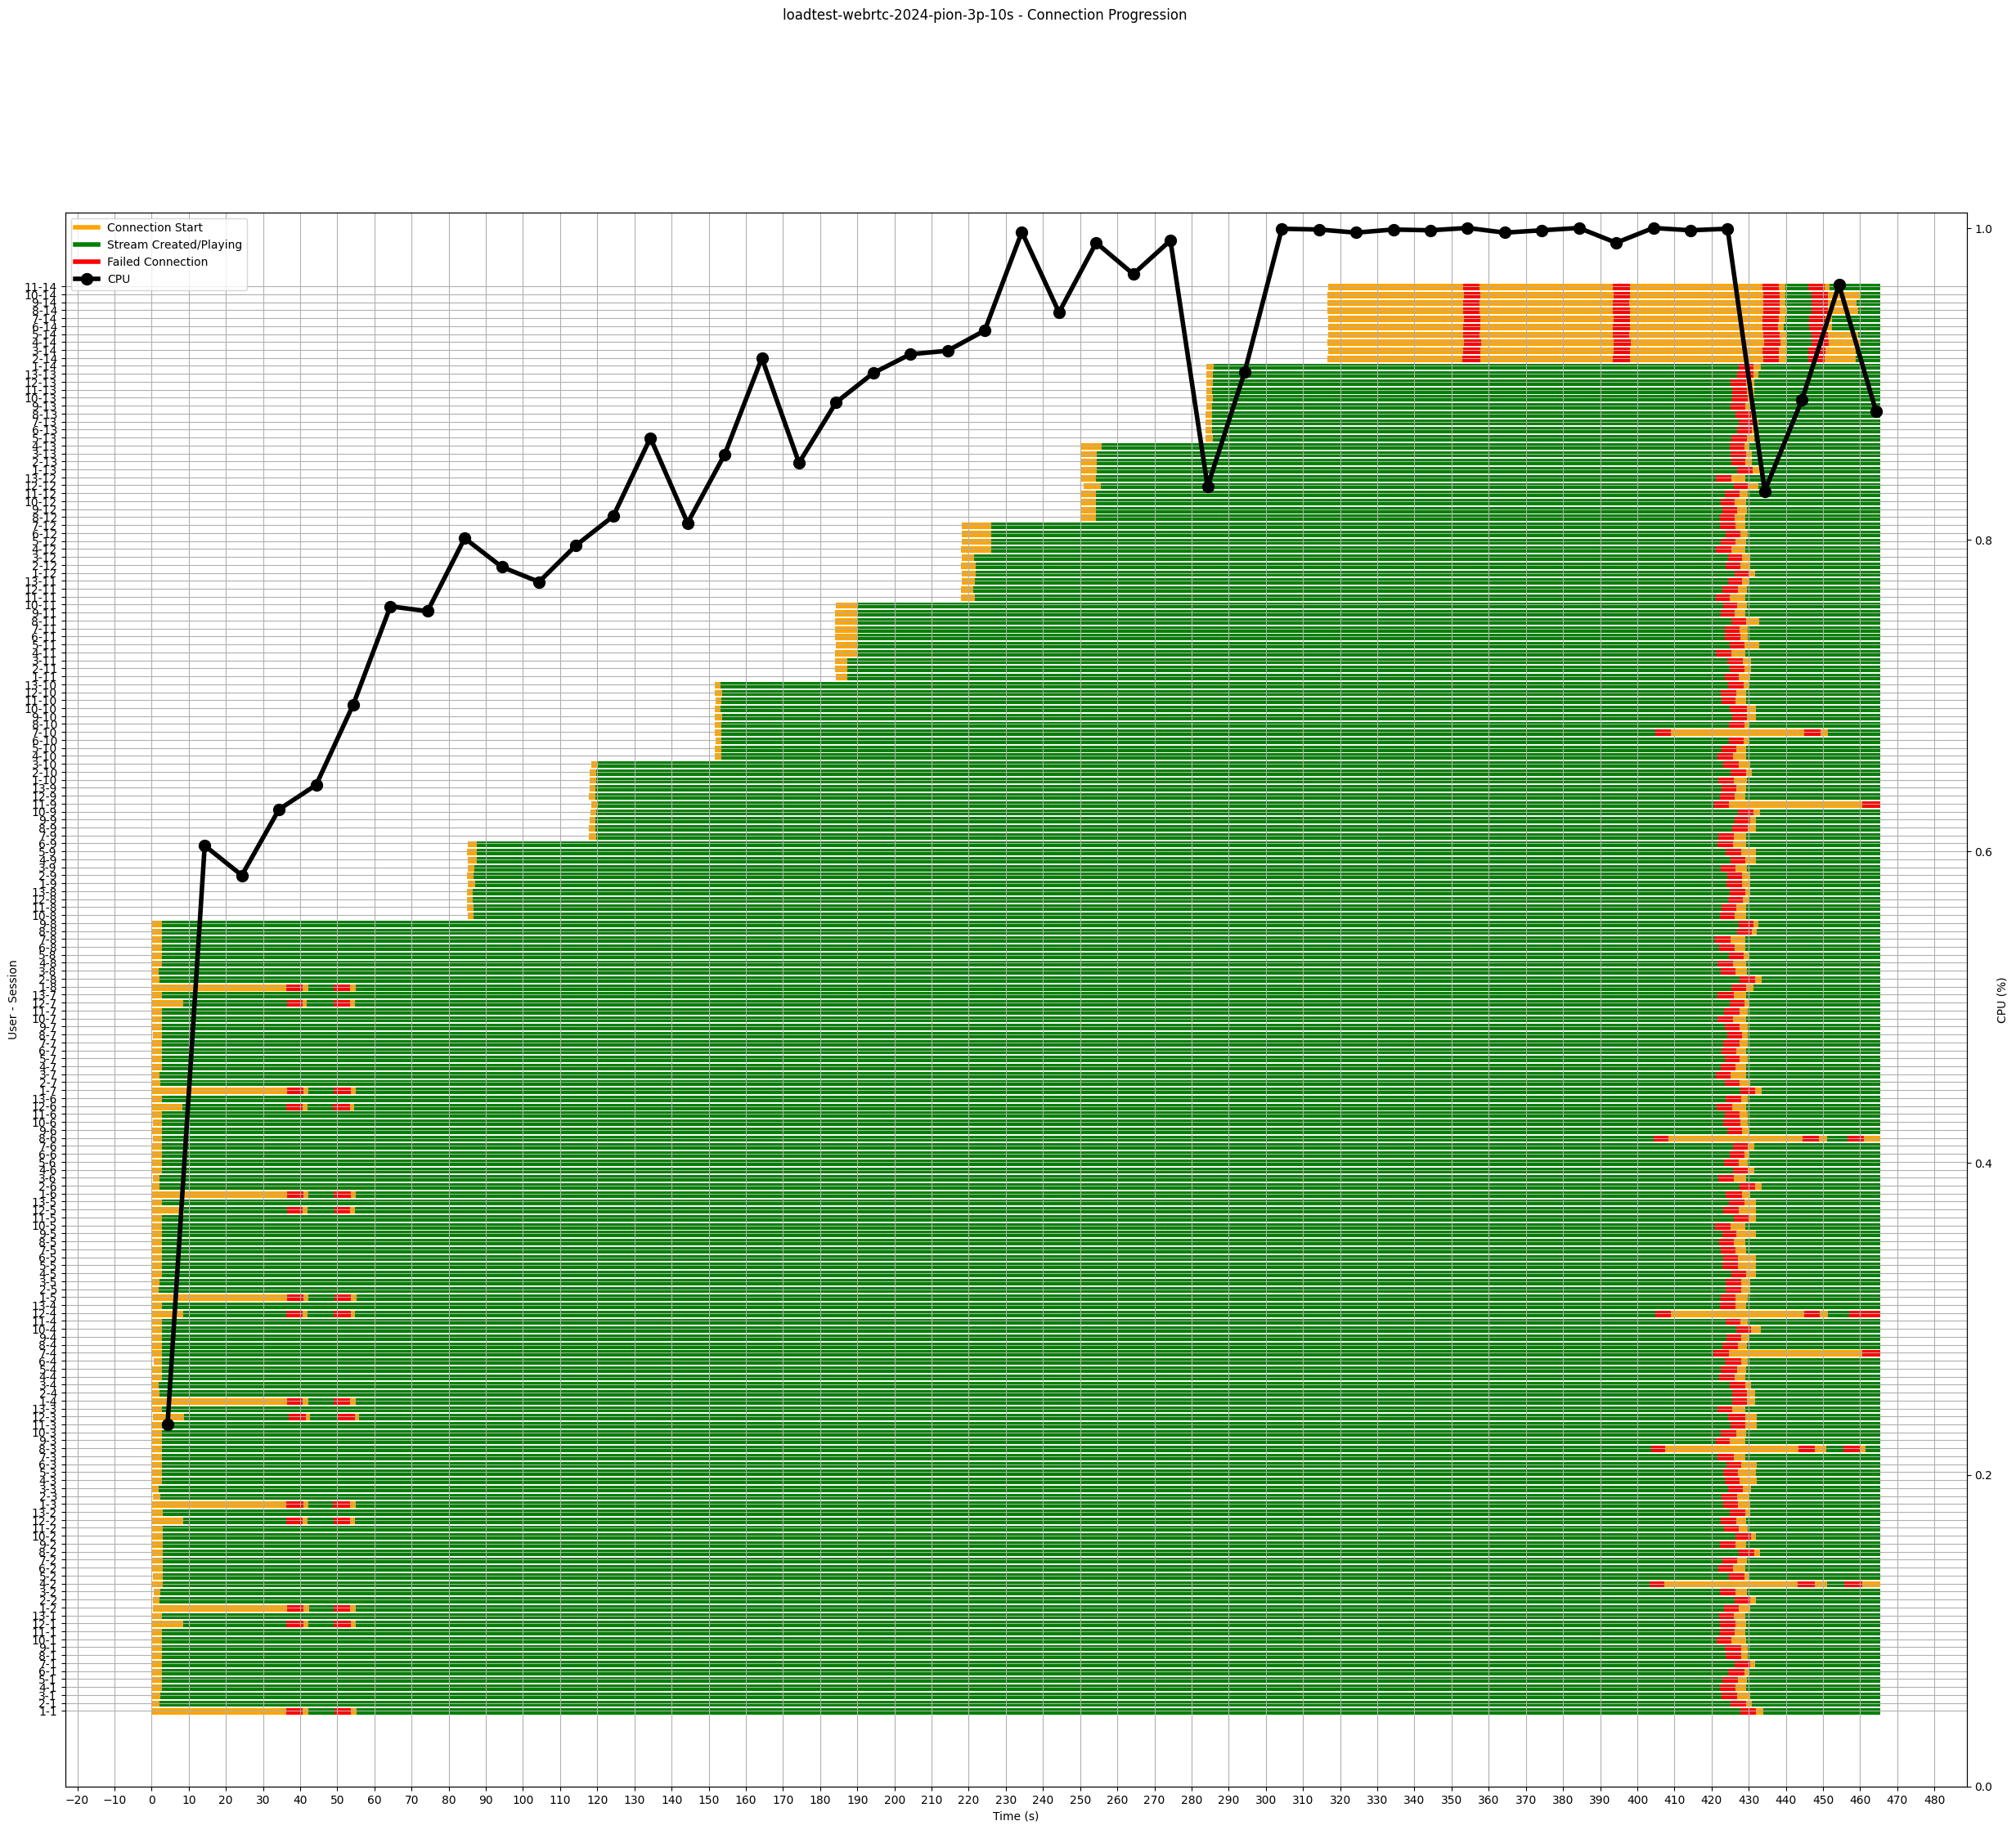

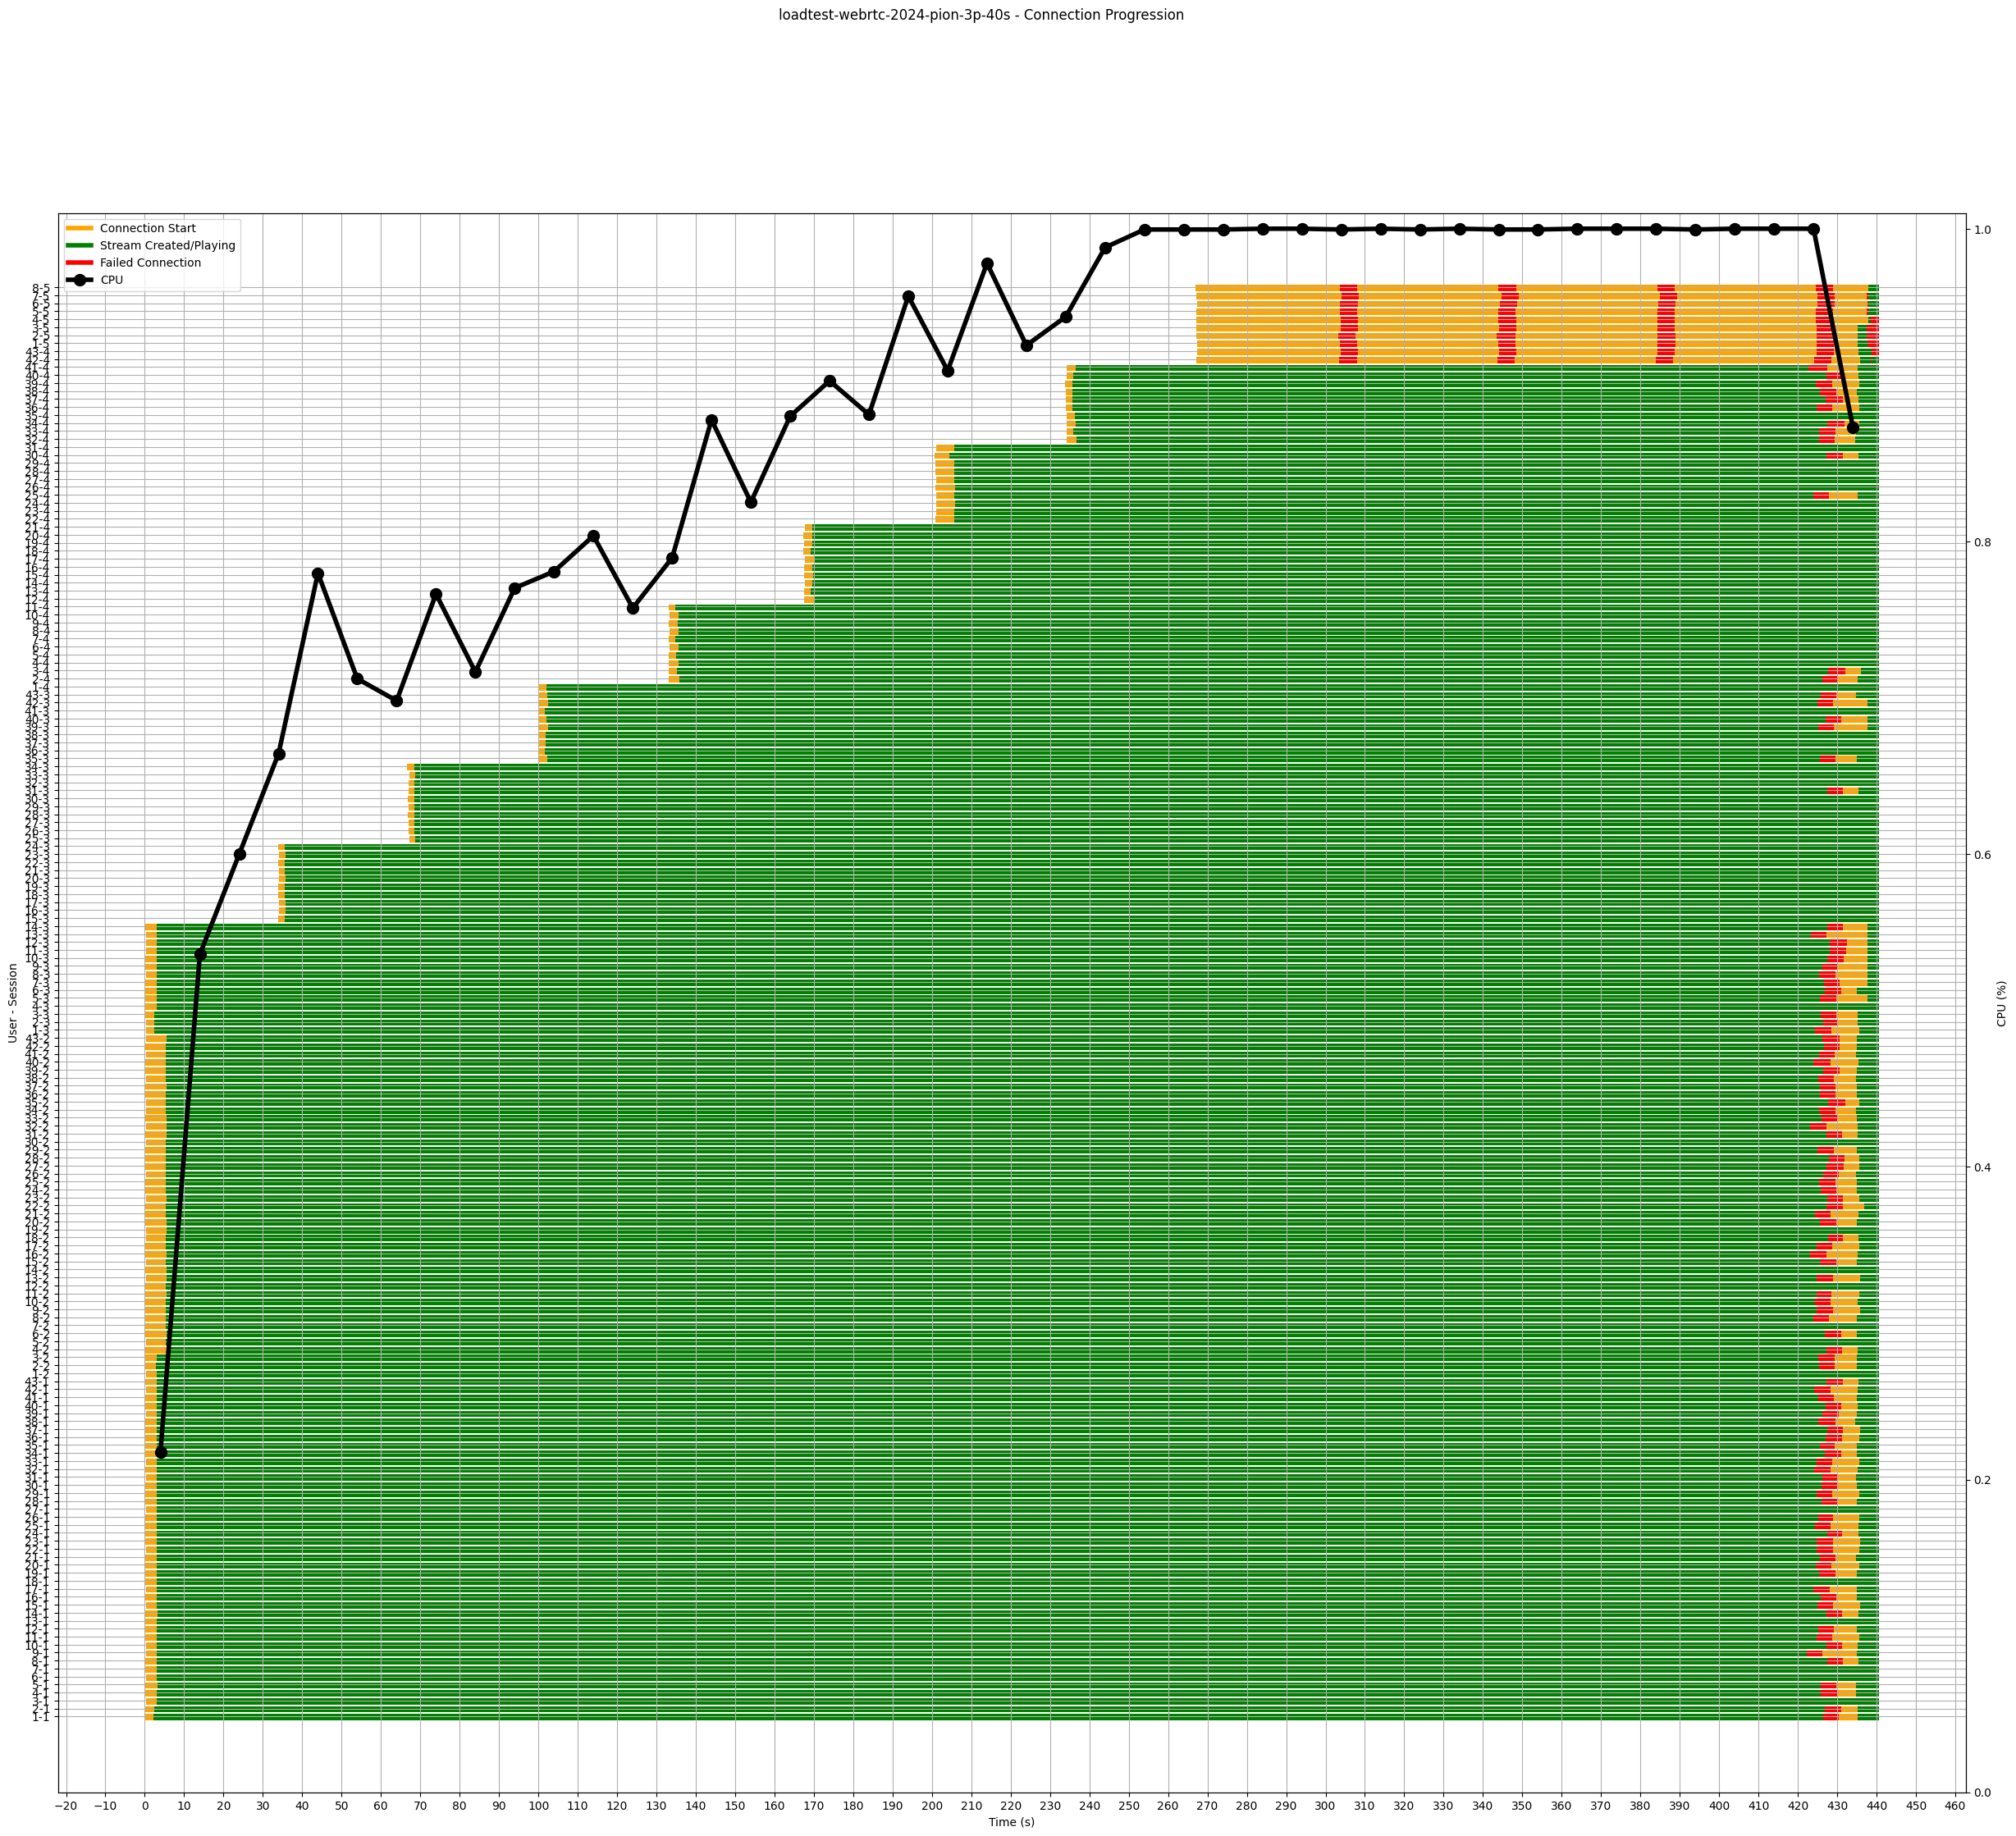

In [15]:
plt.rcParams["figure.figsize"] = [30, 25]

connection_stats_global = pd.DataFrame()
for i, index_list_name in enumerate(index_list_names):
    events_df = events_dfs[index_list_name]
    events_df = events_df.sort_values(by=["session", "user", "timestamp"])
    start_time = events_df["timestamp"].min()
    end_time = events_df["timestamp"].max()
    test_duration = (end_time - start_time).total_seconds()
    sessions = events_df["session"].unique()
    connection_stats = []
    full_users = []
    fig, ax = plt.subplots()
    y_labels = []
    y_ticks = 0
    user_count = 0
    for session in sessions:
        users = events_df[events_df["session"] == session]["user"].unique()
        for user in users:
            user_count += 1
            full_user = f"{user}-{session}"
            y_labels.append(full_user)
            y_ticks += 1
            user_events = events_df[
                (events_df["session"] == session) & (events_df["user"] == user)
            ]
            connection_starts = user_events[user_events["event"] == "connectionStart"]
            failures_user = failures[index_list_name][
                (failures[index_list_name]["full_user"] == full_user) &
                (failures[index_list_name]["timestamp"] >= start_time) &
                (failures[index_list_name]["timestamp"] <= end_time)
            ]
            if "kurento" in index_list_name:
                if ("8p" in index_list_name) or (user <= 3):
                    stream_created_locals = user_events[
                        user_events["event"] == "streamCreated-local"
                    ]
                    stream_playing_locals = user_events[
                        user_events["event"] == "streamPlaying-local"
                    ]
                else:
                    # we choose the first stream created as confirmation of media connection if the user is subscriber
                    stream_created_locals = user_events[
                        user_events["event"].str.startswith("streamCreated")
                    ]
                    stream_playing_locals = user_events[
                        user_events["event"].str.startswith("streamPlaying")
                    ]
                # combine connection starts and stream created locals and failures_user
                combined = pd.concat(
                    [
                        connection_starts,
                        stream_created_locals,
                        stream_playing_locals,
                        failures_user,
                    ]
                )
            else:
                if ("8p" in index_list_name) or (user <= 3):
                    stream_created_locals = user_events[
                        user_events["event"] == "LocalTrackPublished-local"
                    ]
                    stream_created_locals = stream_created_locals.sort_values(by="timestamp")
                    # The second one means the publisher has fully connected
                    stream_created_locals = stream_created_locals.iloc[::2, :]
                else:
                    # we choose the first stream created as confirmation of media connection if the user is subscriber
                    stream_created_locals = user_events[
                        user_events["event"].str.startswith("TrackSubscribed")
                    ]
                # combine connection starts and stream created locals and failures_user
                combined = pd.concat(
                    [connection_starts, stream_created_locals, failures_user]
                )
            combined = combined.sort_values(by="timestamp")
            next_color = "white"
            prev_time = None
            prev_state = None
            prev_attempt = 0
            for r, row in combined.iterrows():
                current_time = (row["timestamp"] - start_time).total_seconds()
                if prev_time is not None:
                    total_duration = current_time - prev_time
                    segment = [(prev_time, total_duration)]
                    yrange = (y_ticks - 0.5, 0.8)
                    ax.broken_barh(segment, yrange, facecolors=next_color)
                    if next_color == "orange":
                        connection_stats.append({
                            "type": "connectionStart",
                            "total_duration": total_duration,
                            "attempt": prev_attempt
                        })
                    elif next_color == "green":
                        connection_stats.append({
                            "type": "connectionSuccess",
                            "total_duration": total_duration,
                            "attempt": prev_attempt
                        })
                    elif next_color == "red":
                        connection_stats.append({
                            "type": "connectionFail",
                            "total_duration": total_duration,
                            "attempt": prev_attempt
                        })
                connectionSuccessful = not pd.isna(row["event"]) and (
                    row["event"].startswith("streamCreated")
                    or row["event"].startswith("streamPlaying")
                    or row["event"].startswith("LocalTrackPublished")
                    or row["event"].startswith("TrackSubscribed")
                )
                if row["event"] == "connectionStart":
                    if prev_state == "connectionSuccess":
                        next_color = "green"
                    else:
                        next_color = "orange"
                        prev_state = "connectionStart"
                elif connectionSuccessful:
                    next_color = "green"
                    prev_state = "connectionSuccess"
                else:
                    next_color = "red"
                    prev_attempt = row["attempts"]
                    prev_state = "connectionFail"
                prev_time = current_time
            ax.broken_barh(
                [(prev_time, test_duration - prev_time)], yrange, facecolors=next_color
            )
    connection_stats_df = pd.DataFrame(connection_stats)
    # get the average, median, min, max duration of each connection type
    connection_stats_df_mean = connection_stats_df.groupby(["type", "attempt"]).mean().reset_index()
    connection_stats_df_mean = connection_stats_df_mean.rename(columns={"total_duration": "mean_duration"})
    connection_stats_df_median = connection_stats_df.groupby(["type", "attempt"]).median().reset_index()
    connection_stats_df_median = connection_stats_df_median.rename(columns={"total_duration": "median_duration"})
    connection_stats_df_min = connection_stats_df.groupby(["type", "attempt"]).min().reset_index()
    connection_stats_df_min = connection_stats_df_min.rename(columns={"total_duration": "min_duration"})
    connection_stats_df_max = connection_stats_df.groupby(["type", "attempt"]).max().reset_index()
    connection_stats_df_max = connection_stats_df_max.rename(columns={"total_duration": "max_duration"})
    #combine all
    connection_stats_df = pd.merge(connection_stats_df_mean, connection_stats_df_median, on=["type", "attempt"])
    connection_stats_df = pd.merge(connection_stats_df, connection_stats_df_min, on=["type", "attempt"])
    connection_stats_df = pd.merge(connection_stats_df, connection_stats_df_max, on=["type", "attempt"])
    connection_stats_df = connection_stats_df[["type", "attempt", "mean_duration", "median_duration", "min_duration", "max_duration"]]
    #add all rows to connection_stats_global
    if connection_stats_global.empty:
        connection_stats_global = connection_stats_df
        connection_stats_global["index"] = index_list_name
    else:
        connection_stats_df["index"] = index_list_name
        connection_stats_global = pd.concat([connection_stats_global, connection_stats_df])


    ax.set_yticks(range(1, y_ticks + 1))
    ax.set_yticklabels(y_labels)
    fig.suptitle(f"{index_list_name} - Connection Progression")
    # y axis label
    ax.set_ylabel("User - Session")
    # x axis label
    ax.set_xlabel("Time (s)")
    # grid
    ax.grid(True)
    # x axis ticks every 10 seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    # cpu in new axis
    ax2 = ax.twinx()
    ax2.set_ylabel("CPU (%)")
    # ax2 y axis should go from 0 to 1
    ax2.set_ylim(0, 1.01)
    cpu = df_cpu_list[i]
    cpu_filtered = cpu[(cpu["@timestamp"] >= start_time) & (cpu["@timestamp"] <= end_time)]
    cpu_filtered.loc[:, "@timestamp"] = cpu_filtered["@timestamp"].apply(lambda x: (x - start_time).total_seconds())
    ax2.plot(cpu_filtered["@timestamp"], cpu_filtered["cpu"], color="black", marker="o", linewidth=4, markersize=10)
    # create legend
    legend_labels = [
        plt.Line2D([0], [0], color="orange", lw=4, label="Connection Start"),
        plt.Line2D([0], [0], color="green", lw=4, label="Stream Created/Playing"),
        plt.Line2D([0], [0], color="red", lw=4, label="Failed Connection"),
        plt.Line2D([0], [0], color="black", lw=4, label="CPU", marker="o", markersize=10)
    ]
    ax.legend(handles=legend_labels, loc="upper left")

In [16]:
# connection_stats_global number columns should have max 3 decimals
connection_stats_global = connection_stats_global.round(decimals=3)
# sort by attempt, type, index
connection_stats_global = connection_stats_global.sort_values(by=["attempt", "type", "index"])
display(connection_stats_global)

type attempt  mean_duration  median_duration  min_duration  \
4     connectionStart       0          2.935            2.782         2.542   
4     connectionStart       0          1.615            2.620         0.015   
4     connectionStart       0          1.237            0.032         0.016   
4     connectionStart       0          2.745            2.729         2.505   
4     connectionStart       0          5.690            2.362         1.704   
..                ...     ...            ...              ...           ...   
13  connectionSuccess       4          0.657            0.003         0.001   
12  connectionSuccess       4          0.619            0.067         0.002   
13  connectionSuccess       4          4.419            4.122         2.806   
4      connectionFail       5          0.211            0.203         0.074   
13  connectionSuccess       5          0.115            0.005         0.002   

    max_duration                                index  
4          3.557      loadtest-webrtc-2024-kurento-2p  
4          3.576  loadtest-webrtc-2024-kurento-3p-10s  
4          3.460  loadtest-webrtc-2024-kurento-3p-40s  
4          3.027      loadtest-webrtc-2024-kurento-8p  
4         36.632         loadtest-webrtc-2024-pion-2p  
..           ...                                  ...  
13         7.270     loadtest-webrtc-2024-pion-3p-10s  
12         2.527     loadtest-webrtc-2024-pion-3p-40s  
13         6.779         loadtest-webrtc-2024-pion-8p  
4          0.351     loadtest-webrtc-2024-pion-3p-40s  
13         0.582     loadtest-webrtc-2024-pion-3p-40s  

[107 rows x 7 columns]

In [ ]:
# each element in the webrtcStats column is a JSON array of JSONs
# for each JSON, there is a webrtcStats property that is a JSON array of JSONs
# for each JSON, there is an event property that is a string
# we want to count the number of times each event type occurs

def extract_events(row):
    events = []
    webrtc_stats_list = row['webrtcStats']
    for item in webrtc_stats_list:
        if 'event' in item:
            events.append(item['event'])
    return events

stats = user_data[0]['stats']
# Apply the function to each row and collect all events
all_events = []
for index, row in enumerate(stats):
    all_events.extend(extract_events(row))

# Count the occurrences of each event
event_counts = Counter(all_events)

# Convert the Counter to a DataFrame for better visualization
event_counts_df = pd.DataFrame(event_counts.items(), columns=['event', 'count'])

display(event_counts_df)

In [ ]:
stats_events = []
for index, row in enumerate(stats):
    webrtc_stats_list = row['webrtcStats']
    for item in webrtc_stats_list:
        if 'event' in item:
            if item['event'] == 'stats':
                stats_events.append(item)

df = pd.DataFrame(stats_events)
display(df.head())


In [ ]:
df["data"]
normalized_qos = pd.json_normalize(df["data"])
# add df["peerId"] to normalized_qos
normalized_qos["peerId"] = df["peerId"]
display(normalized_qos.head())

In [ ]:
#remove all entries where audio.inbound is an empty list
def not_empty_list(x):
    return x != []
normalized_inbound = normalized_qos[normalized_qos["audio.inbound"].apply(not_empty_list)]

# keep only audio.inbound, video.inbound, remote.audio.outbound, remote.video.outbound and peerID
normalized_inbound = normalized_inbound[["audio.inbound", "video.inbound", "remote.audio.outbound", "remote.video.outbound", "peerId"]]

def expand_column(df, column_name):
    expanded = df[column_name].apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded = pd.json_normalize(expanded)
    return expanded

audio_inbound = expand_column(normalized_inbound, "audio.inbound")
video_inbound = expand_column(normalized_inbound, "video.inbound")
remote_audio_outbound = expand_column(normalized_inbound, "remote.audio.outbound")
remote_video_outbound = expand_column(normalized_inbound, "remote.video.outbound")

In [ ]:
plt_audio_inbound = audio_inbound.loc[:, ["timestamp", "packetRate", "bitrate"]]
plt_audio_inbound["timestamp"] = pd.to_datetime(plt_audio_inbound["timestamp"], unit="ms")

cpu = df_cpu_list[0]
cpu = cpu.drop(columns=["memory"]).dropna()
cpu["@timestamp"] = pd.to_datetime(cpu["@timestamp"], format="ISO8601").dt.tz_localize(None)

publishers_progression["timestamp"] = publishers_progression["timestamp"].dt.tz_localize(None)

# here min_ts is calculated as the minimum datetime of the 3 dataframes
# cpu are time aware while plt_audio_inbound is not
min_ts = pd.concat([cpu["@timestamp"], publishers_progression["timestamp"], plt_audio_inbound["timestamp"]]).min()

cpu_td = pd.DataFrame(columns=["timestamp", "cpu"])

cpu_td["timestamp"] = (cpu["@timestamp"] - min_ts).dt.total_seconds()
cpu_td["cpu"] = cpu["cpu"]

user_td = pd.DataFrame(columns=["timestamp", "publishers"])
user_td["timestamp"] = (publishers_progression["timestamp"] - min_ts).dt.total_seconds()
user_td["publishers"] = publishers_progression["number"]
user_td["label"] = publishers_progression["user"] + "-" + publishers_progression["session"]

plt_audio_inbound["timestamp"] = (plt_audio_inbound["timestamp"] - min_ts).dt.total_seconds()

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--", alpha=0.2)
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
#ax.set_xlim(100, 110)
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Annotate users plot with offset to prevent overlap
texts = [ax2.text(x, y, label) for x, y, label in zip(user_td["timestamp"], user_td["publishers"], user_td["label"])]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black'))

# Commented out third y-axis for bitrate
# ax3 = ax.twinx()
# ax3.set_ylabel("bitrate")
# ax3.spines["right"].set_position(("axes", 1.075))
# ax3.plot(plt_audio_inbound["timestamp"], plt_audio_inbound["bitrate"], label="bitrate", linestyle="-")

fig.legend(loc='upper right')
fig.suptitle("Users over time")

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_audio_inbound["timestamp"], plt_audio_inbound["packetRate"], label="packet rate", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio rate over time")

In [ ]:
#remove all entries where audio.inbound is an empty list
def not_empty_list(x):
    return x != []
normalized_outbound = normalized_qos[normalized_qos["audio.outbound"].apply(not_empty_list)]

# keep only audio.inbound, video.inbound, remote.audio.outbound, remote.video.outbound and peerID
normalized_outbound = normalized_outbound[["audio.outbound", "video.outbound", "remote.audio.inbound", "remote.video.inbound", "peerId"]]

def expand_column(df, column_name):
    expanded = df[column_name].apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded = pd.json_normalize(expanded)
    return expanded

audio_outbound = expand_column(normalized_outbound, "audio.outbound")
video_outbound = expand_column(normalized_outbound, "video.outbound")
remote_audio_inbound = expand_column(normalized_outbound, "remote.audio.inbound")
remote_video_inbound = expand_column(normalized_outbound, "remote.video.inbound")

In [ ]:
plt_remote_audio_inbound = remote_audio_inbound.loc[:, ["timestamp", "roundTripTime"]]
plt_remote_audio_inbound["timestamp"] = pd.to_datetime(plt_remote_audio_inbound["timestamp"], unit="ms")

min_ts = pd.concat([cpu["@timestamp"], user_join["@timestamp"], plt_remote_audio_inbound["timestamp"]]).min()

cpu_td["timestamp"] = (cpu["@timestamp"] - min_ts).dt.total_seconds()

user_td["timestamp"] = (user_join["@timestamp"] - min_ts).dt.total_seconds()

plt_remote_audio_inbound["timestamp"] = (plt_remote_audio_inbound["timestamp"] - min_ts).dt.total_seconds()

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_remote_audio_inbound["timestamp"], plt_remote_audio_inbound["roundTripTime"], label="roundTripTime", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio RTT (s) over time")

ax3.axhline(y=0.1, color="green", linestyle="-", label="good rtt")
ax3.axhline(y=0.2, color="orange", linestyle="-", label="mediocre rtt")

In [ ]:
# list of directories in stats/
dirs = os.listdir("stats/")
# read all events.json in each subdir
events = []
for i, dir in enumerate(dirs):
    subdirs = os.listdir(f"stats/{dir}")
    for subdir in subdirs:
        with open(f"stats/{dir}/{subdir}/events.json") as f:
            events.extend(json.load(f))

In [ ]:
connection_start_fn = lambda x: (x['event'] == 'connectionStart')
connection = list(filter(connection_start_fn, events))

connection_df = pd.DataFrame(columns=["user", "session", "time to connect (s)", "connection start time", "stream created time"])
for i, conn in enumerate(connection):
    participant = conn['participant']
    session = conn['session']
    connection_start = conn['timestamp']
    stream_created = list(filter(lambda x: (x['event'] == 'streamCreated') and (x['connection'] == 'local') and (x['participant'] == participant) and (x['session'] == session), events))
    if len(stream_created) > 1:
        print(f"More than one stream created for connection {participant}-{session}")
    if len(stream_created) == 0:
        print(f"No stream created for connection {participant}-{session}")
        continue
    created_time = stream_created[0]['timestamp']
    # convert to datetime
    connection_start = datetime.strptime(connection_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    created_time = datetime.strptime(created_time, '%Y-%m-%dT%H:%M:%S.%fZ')
    time_diff = (created_time - connection_start).total_seconds()
    connection_df.loc[i] = [participant, session, time_diff, connection_start, created_time]

#display(connection_df)

#bar chart of time to connect
plt.rcParams["figure.figsize"] = [25, 10]
fig, ax = plt.subplots()
ax.bar(connection_df["user"] + "-"+ connection_df["session"], connection_df["time to connect (s)"])
ax.set_xlabel("user-session")
ax.set_ylabel("time to connect (s)")
# rotate x labels
plt.xticks(rotation=90)

ax.grid()
fig.suptitle("Time to publish for each connection (s)")